In [1]:
############################################################################
################       █████   █████████  ███████████       ################ 
################      ░░███   ███░░░░░███░█░░░███░░░█       ################ 
################       ░███  ███     ░░░ ░   ░███  ░        ################ 
################       ░███ ░███             ░███           ################ 
################       ░███ ░███             ░███           ################ 
################       ░███ ░░███     ███    ░███           ################ 
################       █████ ░░█████████     █████          ################ 
################       ░░░░░   ░░░░░░░░░     ░░░░░          ################ 
############################################################################
########                  CDW Fitting Equations                   ##########
################           Project: R27-252 EV             #################
########          Originally written by: Johann Cardenas         ###########
############################################################################

# Created on Tue Aug 20 16:05:00 2024
# Last modified on Tue Ago 20 21:00:00 2024
# @author: Johann-Cardenas

## **Extrapolating Responses**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from scipy.interpolate import interp1d
from sklearn.preprocessing import LabelEncoder
from scipy.optimize import minimize_scalar
from scipy.optimize import curve_fit

## **LEF**
From AASHTO, 1993

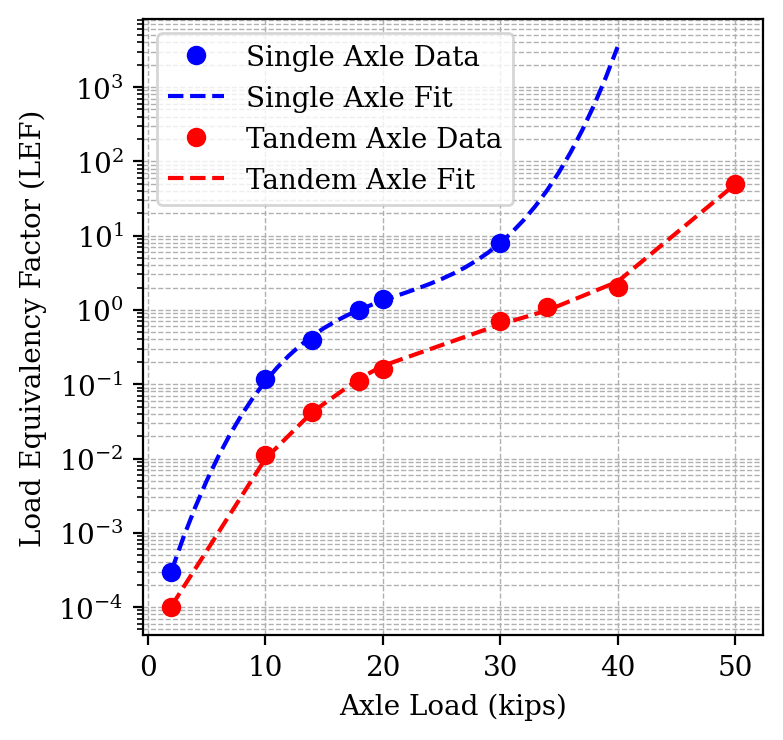

('log10(LEF) = 0.0004x³ + -0.0233x² + 0.5541x + -4.5362',
 'log10(LEF) = 0.0001x³ + -0.0106x² + 0.3607x + -4.6692')

In [50]:
# Data for Single Axle
single_axle_loads = np.array([2, 10, 14, 18, 20, 30])
single_axle_lef = np.array([0.0003, 0.118, 0.399, 1, 1.4, 7.9])

# Data for Tandem Axle
tandem_axle_loads = np.array([2, 10, 14, 18, 20, 30, 34, 40, 50])
tandem_axle_lef = np.array([0.0001, 0.011, 0.042, 0.109, 0.162, 0.703, 1.11, 2.06, 50.3])

# Define a 3rd-degree polynomial function for curve fitting
def polynomial_3rd(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

# Log-transform the LEF values for fitting
log_single_axle_lef = np.log10(single_axle_lef)
log_tandem_axle_lef = np.log10(tandem_axle_lef)

# Fit the data for Single Axle with a 3rd degree polynomial
popt_single, _ = curve_fit(polynomial_3rd, single_axle_loads, log_single_axle_lef)
single_axle_fit_log = polynomial_3rd(single_axle_loads, *popt_single)
single_axle_fit = 10**single_axle_fit_log  # Convert back to the original scale

# Fit the data for Tandem Axle with a 4th degree polynomial using log-transformed LEF values
popt_tandem, _ = curve_fit(polynomial_3rd, tandem_axle_loads, log_tandem_axle_lef)
tandem_axle_fit_log = polynomial_3rd(tandem_axle_loads, *popt_tandem)
tandem_axle_fit = 10**tandem_axle_fit_log  # Convert back to the original scale

# Extend single axle loads up to 50 kips
extended_single_axle_loads = np.arange(2, 41, 1)  # from 2 to 40 kips
extended_single_axle_fit_log = polynomial_3rd(extended_single_axle_loads, *popt_single)
extended_single_axle_fit = 10**extended_single_axle_fit_log  # Convert back to the original scale

# Plotting with log scale on Y-axis
plt.figure(figsize=(4, 4), dpi=200)
plt.rc('font', family='serif')
plt.plot(single_axle_loads, single_axle_lef, 'bo', label='Single Axle Data')
plt.plot(extended_single_axle_loads, extended_single_axle_fit, 'b--', label=f'Single Axle Fit')
plt.plot(tandem_axle_loads, tandem_axle_lef, 'ro', label='Tandem Axle Data')
plt.plot(tandem_axle_loads, tandem_axle_fit, 'r--', label=f'Tandem Axle Fit')

plt.yscale('log')
plt.xlabel('Axle Load (kips)')
plt.ylabel('Load Equivalency Factor (LEF)')
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.show()

# Final regression equations
single_axle_eq = f"log10(LEF) = {popt_single[0]:.4f}x³ + {popt_single[1]:.4f}x² + {popt_single[2]:.4f}x + {popt_single[3]:.4f}"
tandem_axle_eq = f"log10(LEF) = {popt_tandem[0]:.4f}x³ + {popt_tandem[1]:.4f}x² + {popt_tandem[2]:.4f}x + {popt_tandem[3]:.4f}"

single_axle_eq, tandem_axle_eq

In [51]:
# # Predict LEF for the following tandem loads: 29, 34, 38
# tandem_loads = np.array([33.6, 37.6])
# tandem_loads_log = polynomial_4th(tandem_loads, *popt_tandem)
# tandem_lef_predictions = 10**tandem_loads_log
# tandem_lef_predictions

# Predict LEF for the following single axles: 24, 26, 28, 30, 32, 34, 36, 38
single_loads = np.array([24, 28, 38])
single_loads_log = polynomial_3rd(single_loads, *popt_single)
single_lef_predictions = 10**single_loads_log
single_lef_predictions


array([  2.24063077,   4.62988669, 572.21574114])

In [53]:
# Predict LEF for the following single axle loads: 20, 24, 28, 38
single_loads = np.array([20, 24, 28, 32])
single_loads_log = polynomial_3rd(single_loads, *popt_single)
single_lef_predictions = 10**single_loads_log
single_lef_predictions

array([ 1.33191447,  2.24063077,  4.62988669, 16.18982887])

## **Regression Analysis**

In [54]:
# Creating the DataFrame
data = {
    'CaseName': ['FD_P1_SL0', 'FD_P1_SL2', 'FD_P5_SL0', 'FD_P5_SL3', 'FD_P3_SL0', 'FD_P2_SL0', 'FD_P2_SL2', 'FD_P6_SL0', 'FD_P6_SL6', 'FD_P4_SL0', 'FD_P4_SL6'],
    'Tire Type': ['ST', 'ST', 'ST', 'ST', 'ST', 'DTA', 'DTA', 'DTA', 'DTA', 'DTA', 'DTA'],
    'Load (kip)': [6.00, 6.00, 7.00, 7.00, 9.50, 4.20, 4.20, 4.20, 4.20, 4.70, 4.70],
    'Slip Ratio': ['0%', '2%', '0%', '3%', '0%', '0%', '2%', '0%', '6%', '0%', '6%'],
    'e11-HMA': [57.9243, 56.652, 67.2787, 65.0506, 86.8035, 66.4725, 65.739, 66.5973, 64.9395, 73.7862, 71.7091],
    'e23-HMA': [154.492, 155.507, 176.7875, 171.6585, 231.048, 113.8235, 115.629, 113.929, 107.222, 126.532, 120.189],
    'e13-HMA': [28.9568, 79.9135, 37.09325, 103.3405, 63.8575, 24.4287, 53.933, 24.4287, 64.8305, 24.81245, 72.3455],
    'e22-HMA1': [[-2.98E-04, -2.79E-04, -2.63E-04, -2.54E-04, -2.47E-04, -2.39E-04, -2.31E-04, -2.24E-04],
                 [-3.08E-04, -2.92E-04, -2.72E-04, -2.57E-04, -2.44E-04, -2.32E-04, -2.21E-04, -2.11E-04],
                 [-2.87E-04, -2.68E-04, -2.53E-04, -2.46E-04, -2.41E-04, -2.37E-04, -2.34E-04, -2.31E-04],
                 [-2.88E-04, -2.80E-04, -2.64E-04, -2.51E-04, -2.41E-04, -2.32E-04, -2.24E-04, -2.18E-04],
                 [-2.79E-04, -2.58E-04, -2.42E-04, -2.35E-04, -2.31E-04, -2.31E-04, -2.34E-04, -2.39E-04],
                 [-2.03E-04, -1.84E-04, -1.80E-04, -1.85E-04, -1.89E-04, -1.87E-04, -1.81E-04, -1.73E-04],
                 [-1.87E-04, -1.73E-04, -1.67E-04, -1.69E-04, -1.70E-04, -1.69E-04, -1.63E-04, -1.56E-04],
                 [-2.01E-04, -1.84E-04, -1.82E-04, -1.89E-04, -1.94E-04, -1.93E-04, -1.86E-04, -1.78E-04],
                 [-1.63E-04, -1.63E-04, -1.61E-04, -1.63E-04, -1.64E-04, -1.63E-04, -1.58E-04, -1.53E-04],
                 [-2.05E-04, -1.86E-04, -1.82E-04, -1.91E-04, -1.98E-04, -1.99E-04, -1.94E-04, -1.87E-04],
                 [-1.75E-04, -1.72E-04, -1.68E-04, -1.69E-04, -1.71E-04, -1.71E-04, -1.67E-04, -1.61E-04]],
    'e22-HMA2': [[-8.80E-06, -4.86E-05, -6.69E-05, -6.55E-05, -6.35E-05, -6.07E-05, -5.73E-05, -5.44E-05],
               [-6.00E-06, -4.33E-05, -6.05E-05, -5.93E-05, -5.75E-05, -5.51E-05, -5.22E-05, -4.98E-05],
               [-3.97E-06, -4.74E-05, -6.82E-05, -6.76E-05, -6.63E-05, -6.42E-05, -6.13E-05, -5.90E-05],
               [-3.21E-08, -4.07E-05, -6.00E-05, -5.94E-05, -5.83E-05, -5.66E-05, -5.43E-05, -5.25E-05],
               [1.00E-05, -3.93E-05, -6.39E-05, -6.50E-05, -6.54E-05, -6.50E-05, -6.38E-05, -6.31E-05],
               [2.14E-06, -3.02E-05, -4.50E-05, -4.41E-05, -4.25E-05, -4.05E-05, -3.79E-05, -3.58E-05],
               [6.75E-06, -2.38E-05, -3.84E-05, -3.81E-05, -3.72E-05, -3.58E-05, -3.39E-05, -3.23E-05],
               [3.99E-07, -3.26E-05, -4.76E-05, -4.65E-05, -4.47E-05, -4.24E-05, -3.95E-05, -3.72E-05],
               [7.82E-06, -2.25E-05, -3.71E-05, -3.70E-05, -3.62E-05, -3.50E-05, -3.32E-05, -3.17E-05],
               [2.85E-06, -3.28E-05, -4.92E-05, -4.83E-05, -4.67E-05, -4.45E-05, -4.18E-05, -3.95E-05],
               [9.83E-06, -2.28E-05, -3.85E-05, -3.86E-05, -3.79E-05, -3.67E-05, -3.50E-05, -3.36E-05]],
    'e22-HMA3': [[-1.25E-05, -2.88E-05, -3.64E-05, -3.70E-05, -3.76E-05, -3.84E-05, -3.97E-05, -4.17E-05, -4.48E-05, -4.95E-05, -5.68E-05, -6.64E-05],
               [-1.08E-05, -2.63E-05, -3.38E-05, -3.45E-05, -3.54E-05, -3.65E-05, -3.80E-05, -4.01E-05, -4.33E-05, -4.81E-05, -5.53E-05, -6.47E-05],
               [-1.29E-05, -3.14E-05, -4.04E-05, -4.13E-05, -4.24E-05, -4.37E-05, -4.55E-05, -4.80E-05, -5.19E-05, -5.76E-05, -6.62E-05, -7.74E-05],
               [-1.01E-05, -2.76E-05, -3.63E-05, -3.76E-05, -3.90E-05, -4.07E-05, -4.28E-05, -4.56E-05, -4.96E-05, -5.54E-05, -6.40E-05, -7.49E-05],
               [-1.07E-05, -3.36E-05, -4.54E-05, -4.77E-05, -5.02E-05, -5.29E-05, -5.63E-05, -6.07E-05, -6.65E-05, -7.47E-05, -8.65E-05, -1.01E-04],
               [-4.77E-06, -1.77E-05, -2.45E-05, -2.60E-05, -2.78E-05, -2.99E-05, -3.25E-05, -3.59E-05, -4.01E-05, -4.58E-05, -5.33E-05, -6.24E-05],
               [-3.34E-06, -1.60E-05, -2.27E-05, -2.45E-05, -2.64E-05, -2.87E-05, -3.15E-05, -3.49E-05, -3.93E-05, -4.49E-05, -5.24E-05, -6.14E-05],
               [-5.50E-06, -1.85E-05, -2.52E-05, -2.67E-05, -2.83E-05, -3.04E-05, -3.29E-05, -3.61E-05, -4.03E-05, -4.59E-05, -5.34E-05, -6.25E-05],
               [-3.12E-06, -1.57E-05, -2.24E-05, -2.42E-05, -2.61E-05, -2.84E-05, -3.12E-05, -3.45E-05, -3.88E-05, -4.44E-05, -5.19E-05, -6.07E-05],
               [-5.29E-06, -1.96E-05, -2.71E-05, -2.88E-05, -3.08E-05, -3.32E-05, -3.61E-05, -3.98E-05, -4.45E-05, -5.08E-05, -5.92E-05, -6.93E-05],
               [-2.86E-06, -1.65E-05, -2.39E-05, -2.60E-05, -2.83E-05, -3.09E-05, -3.40E-05, -3.79E-05, -4.27E-05, -4.89E-05, -5.72E-05, -6.70E-05]],
    'e22-BS': [[9.72E-06, -2.95E-06, -1.52E-05, -2.52E-05, -3.35E-05, -4.09E-05, -4.78E-05, -5.48E-05, -6.26E-05, -7.19E-05, -8.39E-05, -9.69E-05],
               [9.55E-06, -2.80E-06, -1.48E-05, -2.46E-05, -3.28E-05, -4.00E-05, -4.68E-05, -5.38E-05, -6.14E-05, -7.06E-05, -8.23E-05, -9.51E-05],
               [9.60E-06, -4.81E-06, -1.88E-05, -3.02E-05, -3.98E-05, -4.83E-05, -5.63E-05, -6.44E-05, -7.34E-05, -8.42E-05, -9.80E-05, -1.13E-04],
               [9.52E-06, -4.43E-06, -1.80E-05, -2.92E-05, -3.86E-05, -4.69E-05, -5.47E-05, -6.27E-05, -7.15E-05, -8.21E-05, -9.56E-05, -1.10E-04],
               [7.88E-06, -9.79E-06, -2.71E-05, -4.15E-05, -5.38E-05, -6.48E-05, -7.52E-05, -8.58E-05, -9.76E-05, -1.12E-04, -1.30E-04, -1.49E-04],
               [1.53E-05, 3.80E-06, -8.14E-06, -1.88E-05, -2.86E-05, -3.79E-05, -4.72E-05, -5.68E-05, -6.71E-05, -7.89E-05, -9.28E-05, -1.07E-04],
               [1.50E-05, 3.65E-06, -8.14E-06, -1.86E-05, -2.83E-05, -3.75E-05, -4.66E-05, -5.61E-05, -6.63E-05, -7.78E-05, -9.16E-05, -1.06E-04],
               [1.53E-05, 3.70E-06, -8.25E-06, -1.89E-05, -2.87E-05, -3.80E-05, -4.73E-05, -5.68E-05, -6.72E-05, -7.89E-05, -9.28E-05, -1.07E-04],
               [1.48E-05, 3.50E-06, -8.16E-06, -1.85E-05, -2.81E-05, -3.72E-05, -4.62E-05, -5.55E-05, -6.55E-05, -7.70E-05, -9.05E-05, -1.04E-04],
               [1.54E-05, 2.82E-06, -1.02E-05, -2.18E-05, -3.25E-05, -4.27E-05, -5.28E-05, -6.33E-05, -7.47E-05, -8.76E-05, -1.03E-04, -1.19E-04],
               [1.50E-05, 2.76E-06, -9.89E-06, -2.12E-05, -3.16E-05, -4.15E-05, -5.14E-05, -6.16E-05, -7.26E-05, -8.51E-05, -1.00E-04, -1.15E-04]],
    'e22-SG': [[-7.88E-05, -8.62E-05, -9.23E-05, -9.59E-05, -9.71E-05, -9.60E-05, -9.27E-05, -8.92E-05, -4.39E-05],
               [-7.74E-05, -8.46E-05, -9.07E-05, -9.42E-05, -9.54E-05, -9.43E-05, -9.11E-05, -8.77E-05, -4.32E-05],
               [-9.65E-05, -1.04E-04, -1.11E-04, -1.14E-04, -1.15E-04, -1.13E-04, -1.09E-04, -1.05E-04, -5.15E-05],
               [-9.40E-05, -1.02E-04, -1.08E-04, -1.11E-04, -1.12E-04, -1.10E-04, -1.06E-04, -1.02E-04, -5.02E-05],
               [-1.40E-04, -1.48E-04, -1.54E-04, -1.56E-04, -1.56E-04, -1.52E-04, -1.46E-04, -1.39E-04, -6.85E-05],
               [-1.02E-04, -1.09E-04, -1.14E-04, -1.17E-04, -1.19E-04, -1.18E-04, -1.15E-04, -1.11E-04, -5.49E-05],
               [-1.01E-04, -1.07E-04, -1.12E-04, -1.16E-04, -1.17E-04, -1.16E-04, -1.13E-04, -1.10E-04, -5.41E-05],
               [-1.02E-04, -1.09E-04, -1.14E-04, -1.17E-04, -1.19E-04, -1.18E-04, -1.15E-04, -1.11E-04, -5.49E-05],
               [-9.94E-05, -1.06E-04, -1.11E-04, -1.14E-04, -1.16E-04, -1.15E-04, -1.12E-04, -1.08E-04, -5.35E-05],
               [-1.17E-04, -1.23E-04, -1.29E-04, -1.32E-04, -1.33E-04, -1.31E-04, -1.27E-04, -1.23E-04, -6.09E-05],
               [-1.13E-04, -1.20E-04, -1.25E-04, -1.28E-04, -1.29E-04, -1.28E-04, -1.24E-04, -1.20E-04, -5.92E-05]]
}

df = pd.DataFrame(data)
# Convert 'Slip Ratio' to numerical by stripping '%' and converting to float
df['Slip Ratio'] = df['Slip Ratio'].str.rstrip('%').astype('float') / 100.0

In [55]:
# Encode 'Tire Type' as numerical values
label_encoder = LabelEncoder()
df['Tire Type'] = label_encoder.fit_transform(df['Tire Type'])

# Concatenate 'e22' inputs into a single array per row
df['e22'] = df.apply(lambda row: np.concatenate([row['e22-HMA1'], row['e22-HMA2'], row['e22-HMA3'], row['e22-BS'], row['e22-SG']]), axis=1)

# Check that all concatenated arrays have the same length
assert all(len(x) == len(df['e22'][0]) for x in df['e22']), "Inconsistent array lengths in 'e22' concatenation"

# Split the dataset based on Tire Type
df_st = df[df['Tire Type'] == 1]  # Assuming 'ST' is encoded as 1
df_dta = df[df['Tire Type'] == 0]  # Assuming 'DTA' is encoded as 0

# Define the features for both datasets
features = ['Load (kip)', 'Slip Ratio']

# Initialize dictionaries to store models for scalar and array predictions
models_st = {'e11-HMA': None, 'e23-HMA': None, 'e13-HMA': None, 'e22': None}
models_dta = {'e11-HMA': None, 'e23-HMA': None, 'e13-HMA': {}, 'e22': None}

# Train models for scalar targets for ST (e11-HMA, e23-HMA, e13-HMA)
for target in ['e11-HMA', 'e23-HMA', 'e13-HMA']:
    X_st = df_st[features]
    y_st = df_st[target]
    
    model_st = LinearRegression()
    model_st.fit(X_st, y_st)
    
    models_st[target] = model_st

# Train models for scalar targets for DTA (e11-HMA, e23-HMA)
for target in ['e11-HMA', 'e23-HMA']:
    X_dta = df_dta[features]
    y_dta = df_dta[target]
    
    model_dta = LinearRegression()
    model_dta.fit(X_dta, y_dta)
    
    models_dta[target] = model_dta

# Train separate models for e13-HMA for different Slip Ratios for DTA only
for slip_ratio in df_dta['Slip Ratio'].unique():
    df_dta_slip = df_dta[df_dta['Slip Ratio'] == slip_ratio]
    if len(df_dta_slip) > 0:  # Check if the DataFrame is not empty
        X_dta = df_dta_slip[features]
        y_dta = df_dta_slip['e13-HMA']
        
        model_dta = LinearRegression()
        model_dta.fit(X_dta, y_dta)
        
        models_dta['e13-HMA'][slip_ratio] = model_dta
        
# Train model for concatenated e22 targets for ST
X_st = df_st[features]
y_st_e22 = np.array(df_st['e22'].tolist())  # Convert list of arrays into a 2D array

model_st_e22 = LinearRegression()
model_st_e22.fit(X_st, y_st_e22)

models_st['e22'] = model_st_e22

# Train model for concatenated e22 targets for DTA
X_dta = df_dta[features]
y_dta_e22 = np.array(df_dta['e22'].tolist())  # Convert list of arrays into a 2D array

model_dta_e22 = LinearRegression()
model_dta_e22.fit(X_dta, y_dta_e22)

models_dta['e22'] = model_dta_e22

# Example predictions for new data (ensure Slip Ratio used matches trained models)
new_data_st = pd.DataFrame({'Load (kip)': [7.5], 'Slip Ratio': [0.02]})
new_data_dta = pd.DataFrame({'Load (kip)': [4.5], 'Slip Ratio': [0.05]})

new_data_st['Slip Ratio'] = new_data_st['Slip Ratio'].round(2)
new_data_dta['Slip Ratio'] = new_data_dta['Slip Ratio'].round(2)

# Predict e13-HMA separately based on Slip Ratio for DTA
predictions_st = {
    target: model.predict(new_data_st) for target, model in models_st.items() if target != 'e13-HMA'
}
predictions_st['e13-HMA'] = models_st['e13-HMA'].predict(new_data_st)

predictions_dta = {}
for target, model in models_dta.items():
    if target != 'e13-HMA':
        predictions_dta[target] = model.predict(new_data_dta)
    else:
        slip_ratio = new_data_dta['Slip Ratio'].iloc[0]
        if slip_ratio in models_dta['e13-HMA']:
            predictions_dta['e13-HMA'] = models_dta['e13-HMA'][slip_ratio].predict(new_data_dta)
        else:
            print(f"No model available for Slip Ratio: {slip_ratio}")
            predictions_dta['e13-HMA'] = None  # Or handle this case as needed

# Print the slip ratios and models to verify
print("Slip Ratios and Corresponding Models for e13-HMA in DTA:")
for slip_ratio, model in models_dta['e13-HMA'].items():
    print(f"Slip Ratio: {slip_ratio}, Model: {model}")

No model available for Slip Ratio: 0.05
Slip Ratios and Corresponding Models for e13-HMA in DTA:
Slip Ratio: 0.0, Model: LinearRegression()
Slip Ratio: 0.02, Model: LinearRegression()
Slip Ratio: 0.06, Model: LinearRegression()


Plots for ST tire type:


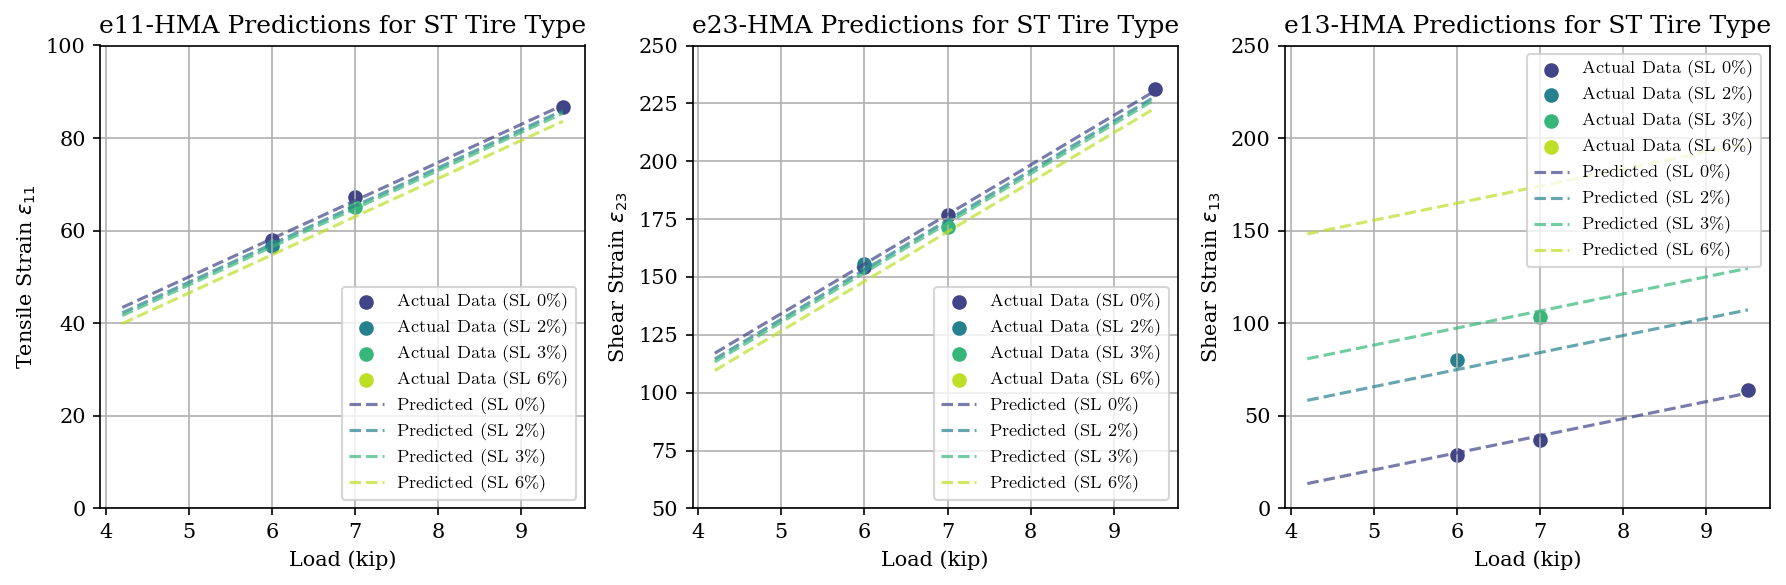

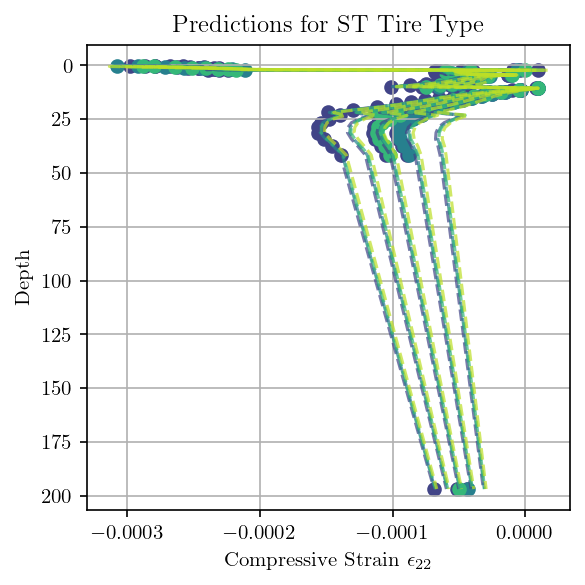

Plots for DTA tire type:


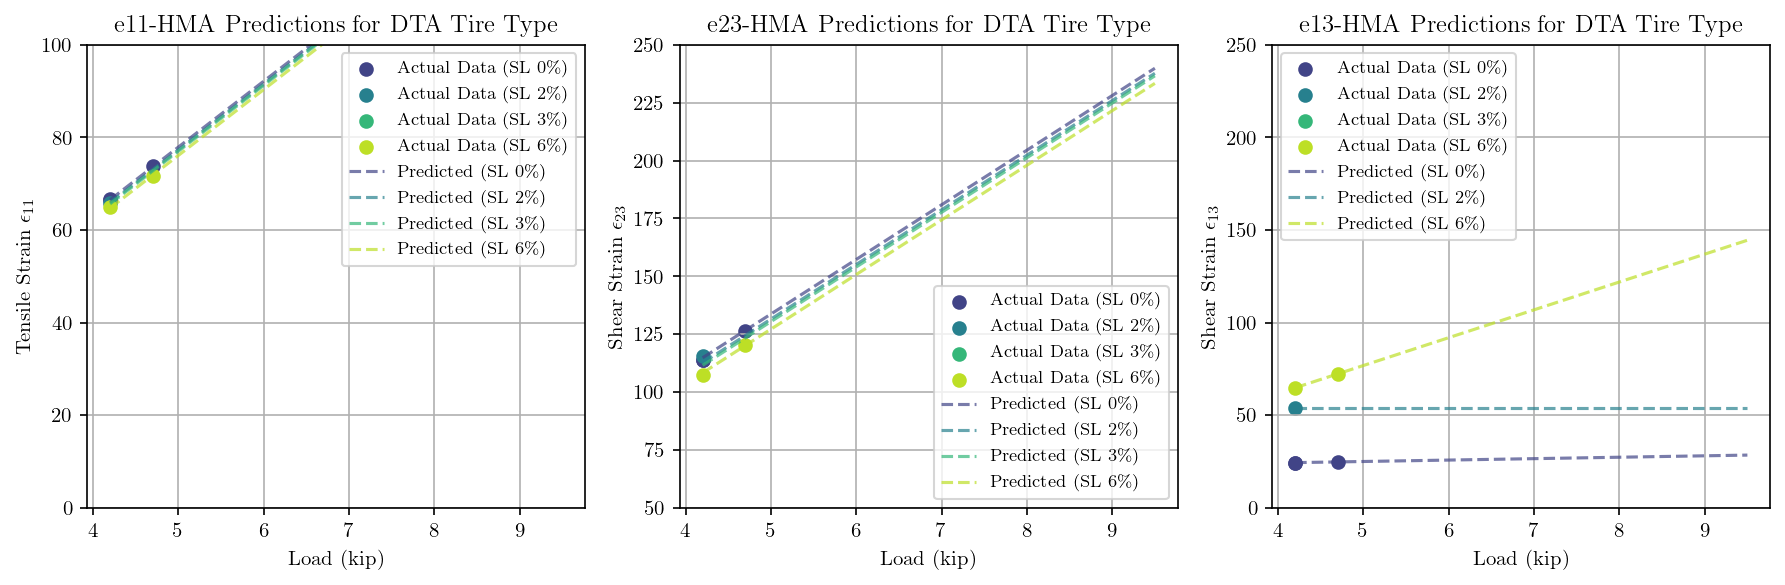

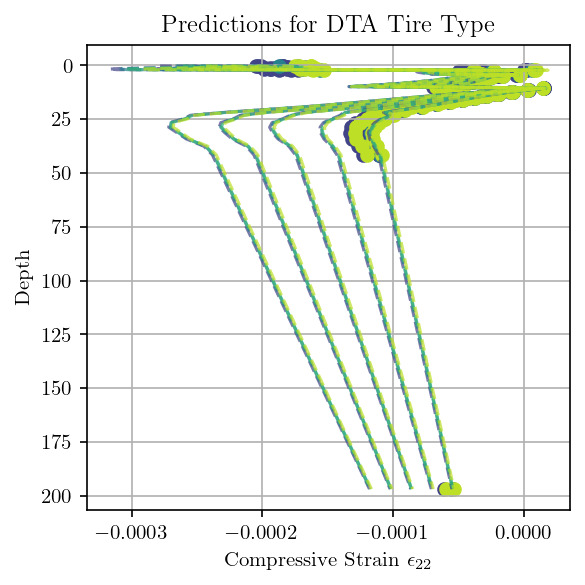

In [56]:
# Define a range of values for Load for prediction
load_range = np.linspace(df['Load (kip)'].min(), df['Load (kip)'].max(), 5)

# Unique slip ratios for differentiation
unique_slip_ratios = df['Slip Ratio'].unique()

# Define colors for plotting different slip ratios
colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(unique_slip_ratios)))

# Depth vector for the Y-axis
depth = [
    0.24015748, 0.480314961, 0.724409449, 0.972440945, 1.216535433, 1.464566929,
    1.716535433, 1.968503937, 2.228346457, 2.488188976, 2.751968504, 3.023622047,
    3.295275591, 3.570866142, 3.850393701, 4.133858268, 4.421259843, 4.736220472,
    5.078740157, 5.448818898, 5.850393701, 6.291338583, 6.763779528, 7.283464567,
    7.846456693, 8.456692913, 9.122047244, 9.842519685, 10.58661417, 11.37007874,
    12.19685039, 13.06299213, 13.97637795, 14.93700787, 15.9488189, 17.01181102,
    18.12992126, 19.30708661, 20.54724409, 21.8503937, 23.18503937, 24.74409449,
    26.57086614, 28.71259843, 31.21653543, 34.1496063, 37.58267717, 41.6023622,
    196.8503937
]

def plot_predictions_separated_by_slip_ratio(models, df, tire_type_label):
    # Plot for e11-HMA, e23-HMA, and e13-HMA
    fig, axes = plt.subplots(1, 3, figsize=(12, 4), dpi=150)
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    for idx, target in enumerate(['e11-HMA', 'e23-HMA', 'e13-HMA']):
        ax = axes[idx]
        for slip_ratio, color in zip(unique_slip_ratios, colors):
            mask = df['Slip Ratio'] == slip_ratio
            ax.scatter(df.loc[mask, 'Load (kip)'], df.loc[mask, target], color=color, label=f'Actual Data (SL {slip_ratio:.0%})'.replace('%', r'\%'))

        for slip_ratio, color in zip(unique_slip_ratios, colors):
            # Adjust prediction logic based on tire type and target
            if tire_type_label == 'ST' or (tire_type_label == 'DTA' and target != 'e13-HMA'):
                model = models[target]
                if model:
                    grid_data = pd.DataFrame({'Load (kip)': load_range, 'Slip Ratio': slip_ratio})
                    predictions = model.predict(grid_data)
                    ax.plot(load_range, predictions, color=color, linestyle='--', alpha=0.7, label=f'Predicted (SL {slip_ratio:.0%})'.replace('%', r'\%'))
            elif tire_type_label == 'DTA' and target == 'e13-HMA':
                # For DTA and e13-HMA, use separate models for each slip ratio
                if isinstance(models[target], dict):
                    model = models[target].get(slip_ratio)
                    if model:
                        grid_data = pd.DataFrame({'Load (kip)': load_range, 'Slip Ratio': slip_ratio})
                        predictions = model.predict(grid_data)
                        ax.plot(load_range, predictions, color=color, linestyle='--', alpha=0.7, label=f'Predicted (SL {slip_ratio:.0%})'.replace('%', r'\%'))
                else:
                    # Fall back in case models[target] is not a dict (i.e., a single model)
                    model = models[target]
                    if model:
                        grid_data = pd.DataFrame({'Load (kip)': load_range, 'Slip Ratio': slip_ratio})
                        predictions = model.predict(grid_data)
                        ax.plot(load_range, predictions, color=color, linestyle='--', alpha=0.7, label=f'Predicted (SL {slip_ratio:.0%})'.replace('%', r'\%'))

        ax.set_title(f'{target} Predictions for {tire_type_label} Tire Type')
        ax.set_xlabel('Load (kip)')
        
        if target == 'e11-HMA':
            ax.set_ylabel('Tensile Strain $\epsilon_{11}$')
            ax.set_ylim(0, 100)
        elif target == 'e23-HMA':
            ax.set_ylabel('Shear Strain $\epsilon_{23}$')
            ax.set_ylim(50, 250)
        elif target == 'e13-HMA':
            ax.set_ylabel('Shear Strain $\epsilon_{13}$')
            ax.set_ylim(0, 250)
            
        ax.legend(loc='best', fontsize='small')
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

    # Plot for concatenated e22 array predictions
    plt.figure(figsize=(4, 4), dpi=150)
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    for slip_ratio, color in zip(unique_slip_ratios, colors):
        mask = df['Slip Ratio'] == slip_ratio

        # Concatenate all e22 actual values for each case
        for idx in mask[mask].index:
            actual_values_concat = np.concatenate([
                df.loc[idx, 'e22-HMA1'], df.loc[idx, 'e22-HMA2'], df.loc[idx, 'e22-HMA3'],
                df.loc[idx, 'e22-BS'], df.loc[idx, 'e22-SG']
            ])
            load_value = df.loc[idx, 'Load (kip)']  # Extract the load value for the legend
            plt.scatter(actual_values_concat, depth[:len(actual_values_concat)], color=color, label=f'Actual Data (P {load_value:.1f} kips, SL {slip_ratio:.0%})'.replace('%', r'\%'))

        # Predict concatenated e22 values for each combination of load and slip ratio
        model = models['e22']
        if model:
            grid_data = pd.DataFrame({'Load (kip)': load_range, 'Slip Ratio': slip_ratio})
            predictions_concat = model.predict(grid_data)

            # Plot predicted e22 values
            for i, load_value in enumerate(load_range):
                plt.plot(predictions_concat[i], depth[:len(predictions_concat[i])], color=color, linestyle='--', alpha=0.7, label=f'Predicted (P {load_value:.1f} kips, SL {slip_ratio:.0%})'.replace('%', r'\%'))

    plt.title(f'Predictions for {tire_type_label} Tire Type')
    plt.xlabel('Compressive Strain $\epsilon_{22}$')
    plt.ylabel('Depth')
    plt.gca().invert_yaxis()  # Invert Y-axis
    plt.legend(loc='lower left')
    # hide legend
    plt.legend().set_visible(False)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot predictions for ST tire type
print("Plots for ST tire type:")
plot_predictions_separated_by_slip_ratio(models_st, df_st, 'ST')

# Plot predictions for DTA tire type
print("Plots for DTA tire type:")
plot_predictions_separated_by_slip_ratio(models_dta, df_dta, 'DTA')

In [18]:

# Define the load and slip ratio values
load_values = np.array([4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5])
slip_ratios = np.array([0.0, 0.02, 0.04, 0.06])

# Create a grid of load and slip ratio values
load_grid, slip_ratio_grid = np.meshgrid(load_values, slip_ratios)
load_slip_data = np.array([load_grid.ravel(), slip_ratio_grid.ravel()]).T

## Initialize a dictionary to store all predictions
predictions_dict = {'ST': {}, 'DTA': {}}

# Predict e11-HMA, e23-HMA, and e13-HMA for ST tire type
for target in ['e11-HMA', 'e23-HMA', 'e13-HMA']:
    predictions_dict['ST'][target] = {}
    predictions_st_target = models_st[target].predict(load_slip_data)
    for i, (load, slip_ratio) in enumerate(zip(load_slip_data[:, 0], load_slip_data[:, 1])):
        predictions_dict['ST'][target][(load, slip_ratio)] = predictions_st_target[i]

# Predict concatenated e22 values for ST tire type
predictions_dict['ST']['e22'] = {}
predictions_st_e22 = models_st['e22'].predict(load_slip_data)
for i, (load, slip_ratio) in enumerate(zip(load_slip_data[:, 0], load_slip_data[:, 1])):
    predictions_dict['ST']['e22'][(load, slip_ratio)] = predictions_st_e22[i]

# Predict e11-HMA, e23-HMA for DTA tire type
for target in ['e11-HMA', 'e23-HMA']:
    predictions_dict['DTA'][target] = {}
    predictions_dta_target = models_dta[target].predict(load_slip_data)
    for i, (load, slip_ratio) in enumerate(zip(load_slip_data[:, 0], load_slip_data[:, 1])):
        predictions_dict['DTA'][target][(load, slip_ratio)] = predictions_dta_target[i]

# Predict e13-HMA for DTA tire type using specific models per slip ratio
predictions_dict['DTA']['e13-HMA'] = {}
for i, (load, slip_ratio) in enumerate(zip(load_slip_data[:, 0], load_slip_data[:, 1])):
    if slip_ratio in models_dta['e13-HMA']:
        model_dta_e13_hma = models_dta['e13-HMA'][slip_ratio]
        prediction_dta_e13_hma = model_dta_e13_hma.predict([[load, slip_ratio]])
        predictions_dict['DTA']['e13-HMA'][(load, slip_ratio)] = prediction_dta_e13_hma[0]
    else:
        predictions_dict['DTA']['e13-HMA'][(load, slip_ratio)] = None  # Handle missing models

# Predict concatenated e22 values for DTA tire type
predictions_dict['DTA']['e22'] = {}
predictions_dta_e22 = models_dta['e22'].predict(load_slip_data)
for i, (load, slip_ratio) in enumerate(zip(load_slip_data[:, 0], load_slip_data[:, 1])):
    predictions_dict['DTA']['e22'][(load, slip_ratio)] = predictions_dta_e22[i]


c:\Users\johan\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\johan\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\johan\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\johan\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\johan\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\johan\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not ha

In [19]:
predictions_dict['ST']['e13-HMA'][(7.0, 0.0)], predictions_dict['ST']['e13-HMA'][(7.0, 0.04)]

(39.24201849199666, 129.11404730412804)

In [20]:
# Define constants and functions for calculations
E_HMA_ST = 1465.52 * 145.037738  # psi
E_HMA_DTA = 1465.52 * 145.037738  # psi
VMA, VFA = 13.7, 61.4
H_HMA = 10.00  # inches
T = 69.80  # Fahrenheit
Thicks = np.array([6.1, 6.1, 6.2, 6.3, 6.2, 6.3, 6.4, 6.4, 
                   6.6, 6.6, 6.7, 6.9, 6.9, 7.0, 7.1, 7.2,
                   7.3, 8.0, 8.7, 9.4, 10.2, 11.2, 12, 13.2, 14.3, 15.5, 16.9, 18.3])/25.4  # in mm
Thicks_granular = np.array([18.9, 19.9, 21.0, 22.0, 23.2, 24.4, 25.7, 27.0, 28.4, 29.9, 31.5, 33.10])/25.4  # in mm
Thicks_sg = np.array([33.90, 39.60, 46.4, 54.4, 63.60, 74.5, 87.2, 102.1, 3943.3])/25.4
Mr_granular = 400 * 145.037738  # convert from MPa to psi
Mr_sg = 70 * 145.037738  # convert from MPa to psi

def BUFC_Nf(e_11, E_HMA, VMA, VFA, H_HMA):
    k_f1, k_f2, k_f3 = 0.007566, -3.9492, -1.281
    V_a = (VMA * (1 - VFA / 100)) / 100
    V_be = (V_a * VFA / 100) / (1 - VFA / 100)
    M = 4.84 * (V_be / (V_a + V_be) - 0.69)
    C = 10 ** M
    C_H = 1 / (0.000398 + 0.003602 / (1 + np.exp(11.02 - 3.49 * H_HMA)))
    N_f = k_f1 * C * C_H * (e_11 ** k_f2) * (E_HMA ** k_f3)
    return int(N_f)

def TDFCS_Nf(e_23, E_HMA, VMA, VFA, H_HMA):
    k_f1, k_f2, k_f3 = 0.007566, -3.9492, -1.281
    V_a = (VMA * (1 - VFA / 100)) / 100
    V_be = (V_a * VFA / 100) / (1 - VFA / 100)
    M = 4.84 * (V_be / (V_a + V_be) - 0.69)
    C = 10 ** M
    C_H = 1 / (0.01 + 12.00 / (1 + np.exp(15.676 - 2.816 * H_HMA)))
    N_f = k_f1 * C * C_H * (e_23 ** k_f2) * (E_HMA ** k_f3)
    return int(N_f)

def Shoving_AC(e12, T = 69.80, Thicks = (np.array([50.8])/25.4)/2 , H_HMA = np.array([50.8])/25.4 , Shov_tol=0.50):
    D = np.cumsum(Thicks)
    def calculate_kz(H_HMA, D):
        C1 = -0.1039 * (H_HMA ** 2) + 2.4868 * H_HMA - 17.342
        C2 = 0.0172 * (H_HMA ** 2) - 1.7331 * H_HMA + 27.428
        with np.errstate(invalid='ignore', divide='ignore'):
            kz = (C1 + C2 * D) * (0.328196 ** D)
            kz = np.where(np.isnan(kz) | np.isinf(kz), 0, kz)
        return kz
    kz = calculate_kz(H_HMA, D)
    def rut_sum(N):
        k1r, k2r, k3r = -3.35412, 0.4791, 1.5606
        beta1r, beta2r, beta3r = 1.00, 1.00, 1.00
        Rut = beta1r * kz * e12 * (10 ** k1r) * (N ** (k2r * beta2r)) * (T ** (k3r * beta3r))
        return np.abs(np.sum(Rut) - Shov_tol)
    result = minimize_scalar(rut_sum, bounds=(1, 1e10), method='bounded')
    return int(result.x)

def rut_total(epsilon_r_HMA, e22_granular, e22_sg, T, Thicks, Thicks_granular, Thicks_sg, H_HMA, Rut_tol):
    D = np.cumsum(Thicks)
    k1r, k2r, k3r = -3.35412, 0.4791, 1.5606
    beta1r, beta2r, beta3r = 1.00, 1.00, 1.00
    betas1, ks1 = 1.00, 0.965
    a1, a9, b1, b9 = 0.15, 20.0, 0.0, 0.0
    GWT = 20

    def calculate_kz(H_HMA, D):
        C1 = -0.1039 * (H_HMA ** 2) + 2.4868 * H_HMA - 17.342
        C2 = 0.0172 * (H_HMA ** 2) - 1.7331 * H_HMA + 27.428
        with np.errstate(invalid='ignore', divide='ignore'):
            kz = (C1 + C2 * D) * (0.328196 ** D)
            kz = np.where(np.isnan(kz) | np.isinf(kz), 0, kz)
        return kz

    def calculate_Wc(Mr, GWT):
        return 51.712 * ((Mr / 2555) ** (1 / 0.64)) ** (-0.3586 * GWT ** 0.1192)

    def calculate_beta(W_c):
        return 10 ** (-0.61119 - 0.017638 * W_c)

    def calculate_C0(a1, a9, Mr, b1, b9):
        return np.log((a1 * Mr ** b1) / (a9 * Mr ** b9))

    def calculate_rho(C0, beta):
        return 10 ** 9 * (C0 / (1 - (10 ** 9) ** beta)) ** (1 / beta)

    def calculate_eratio(rho, beta, a1, a9, Mr, b1, b9):
        return (np.exp(rho ** beta) * a1 * Mr ** b1 + np.exp((rho / 10 ** 9) ** beta) * a9 * Mr ** b9) / 2

    def material_properties(Mr, Thicks):
        Wc = calculate_Wc(Mr, GWT)
        C0 = calculate_C0(a1, a9, Mr, b1, b9)
        beta = calculate_beta(Wc)
        rho = calculate_rho(C0, beta)
        eratio = calculate_eratio(rho, beta, a1, a9, Mr, b1, b9)
        return Wc, C0, beta, rho, eratio

    kz = calculate_kz(H_HMA, D)
    Wc_granular, C0_granular, beta_granular, rho_granular, eratio_granular = material_properties(Mr_granular, Thicks_granular)
    Wc_sg, C0_sg, beta_sg, rho_sg, eratio_sg = material_properties(Mr_sg, Thicks_sg)
    
    def rut_sum(N): 
        Rut = beta1r * kz * epsilon_r_HMA * (10 ** k1r) * (N ** (k2r * beta2r)) * (T ** (k3r * beta3r))
        Rut_granular = betas1 * ks1 * e22_granular * Thicks_granular * eratio_granular * np.exp(-(rho_granular / N) ** beta_granular)
        Rut_sg = betas1 * ks1 * e22_sg * Thicks_sg * eratio_sg * np.exp(-(rho_sg / N) ** beta_sg)
        return np.abs(np.sum(Rut) + np.sum(Rut_granular) + np.sum(Rut_sg) - Rut_tol)
    
    result = minimize_scalar(rut_sum, bounds=(1, 1e10), method='bounded')
    return int(result.x)

# Initialize lists to store the results for the DataFrame
results = []

# Calculate predictions for each combination of load, slip ratio, and tire type
for tire_type in ['ST', 'DTA']:
    for load, slip_ratio in zip(load_slip_data[:, 0], load_slip_data[:, 1]):
        if tire_type == 'ST':
            e11 = predictions_dict['ST']['e11-HMA'][(load, slip_ratio)] * 1E-06
            e23 = predictions_dict['ST']['e23-HMA'][(load, slip_ratio)] * 1E-06
            e13 = predictions_dict['ST']['e13-HMA'][(load, slip_ratio)] * 1E-06
            e22 = predictions_dict['ST']['e22'][(load, slip_ratio)]

            N_BUFC = BUFC_Nf(e11, E_HMA_ST, VMA, VFA, H_HMA)
            N_TDFCS = TDFCS_Nf(e23, E_HMA_ST, VMA, VFA, H_HMA)
            N_NSS = Shoving_AC(e13, T = 69.80, Thicks = (np.array([50.8])/25.4)/2 , H_HMA = np.array([50.8])/25.4, Shov_tol=0.50)
            N_Rutting = rut_total(e22[:28], e22[28:40], e22[-9:], T, Thicks, Thicks_granular, Thicks_sg, H_HMA, -0.50)
            
        elif tire_type == 'DTA':
            e11 = predictions_dict['DTA']['e11-HMA'][(load, slip_ratio)] * 1E-06
            e23 = predictions_dict['DTA']['e23-HMA'][(load, slip_ratio)] * 1E-06
            e13 = predictions_dict['DTA']['e13-HMA'][(load, slip_ratio)] * 1E-06 if predictions_dict['DTA']['e13-HMA'][(load, slip_ratio)] is not None else 0
            e22 = predictions_dict['DTA']['e22'][(load, slip_ratio)]

            N_BUFC = BUFC_Nf(e11, E_HMA_DTA, VMA, VFA, H_HMA)
            N_TDFCS = TDFCS_Nf(e23, E_HMA_DTA, VMA, VFA, H_HMA)
            N_NSS = Shoving_AC(e13, T = 69.80, Thicks = (np.array([50.8])/25.4)/2 , H_HMA = np.array([50.8])/25.4, Shov_tol=0.50)
            N_Rutting = rut_total(e22[:28], e22[28:40], e22[-9:], T, Thicks, Thicks_granular, Thicks_sg, H_HMA, -0.50)

        # Store results in the list
        results.append((tire_type, load, slip_ratio, N_BUFC, N_TDFCS, N_NSS, N_Rutting))

# Convert the list to a DataFrame
df_results = pd.DataFrame(results, columns=['Tire Type', 'Load', 'Slip Ratio', 'N_BUFC', 'N_TDFCS', 'N_NSS', 'N_Rutting'])

#Display a specific case of load and slip ratio
df_results[(df_results['Load'] == 6.0) & (df_results['Slip Ratio'] == 0.0)]

,Tire Type,Load,Slip Ratio,N_BUFC,N_TDFCS,N_NSS,N_Rutting
4,ST,6.0,0.0,6428484913,44212,419228017,111243
52,DTA,6.0,0.0,1051315879,42360,574631093,110453


In [120]:
# Save results in text file at a given path
path = r'C:\Users\johan\Box\05 Repositories\DesignLab\MPEDG'  # Using a raw string for the path
file_path = path + r'\Extrapolation.txt'  # Constructing the full file path

df_results.to_csv(file_path, sep='\t', index=False)

### **Nf**

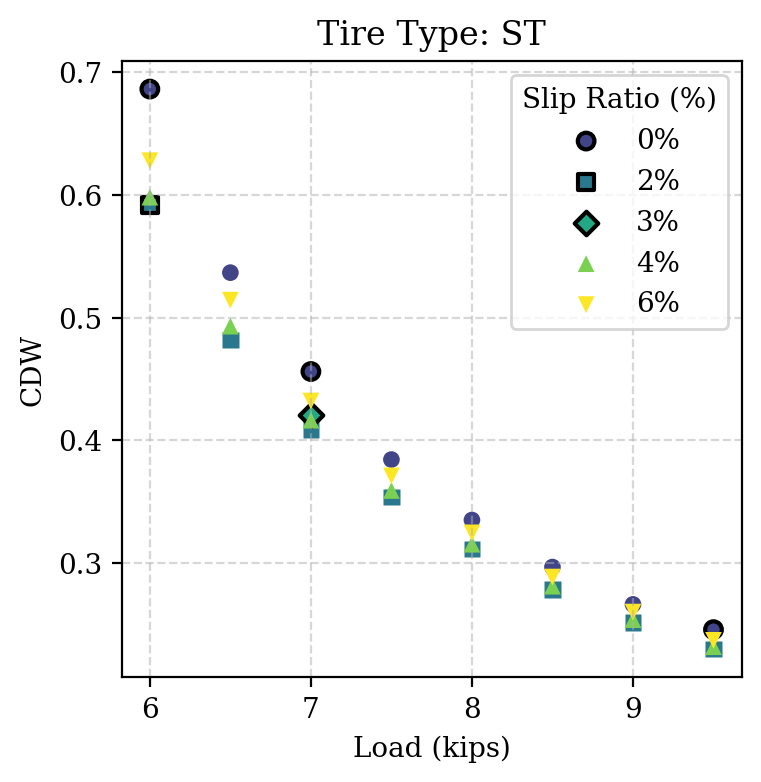

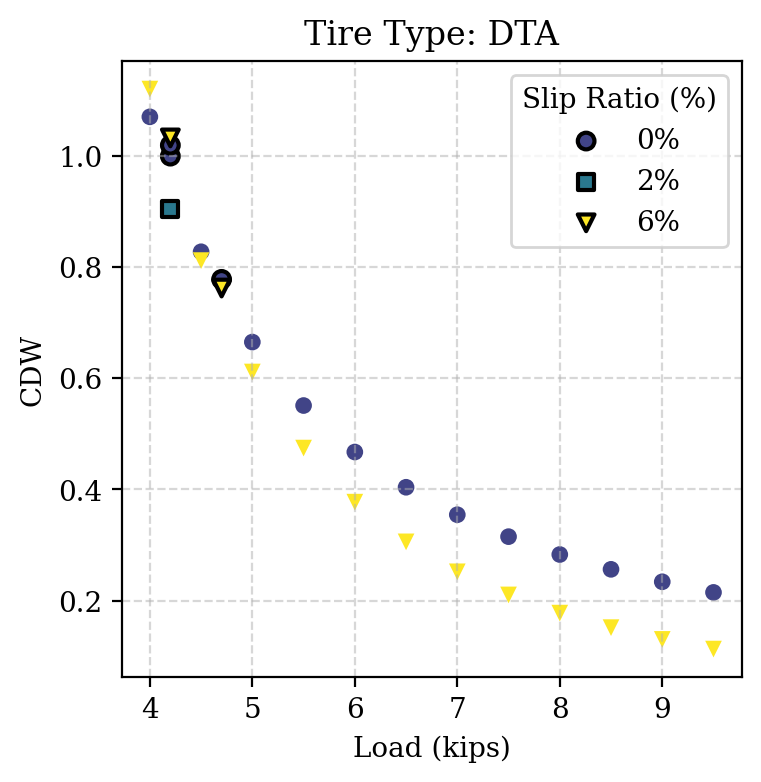

In [60]:
# Load the data from the Excel file
path = r'C:\Users\johan\Box\R27-252 EV\Tasks\Task 4 - Guidelines\Results'  # Using a raw string for the path
file_path = path + r'\Extrapolated_Results.xlsx'  # Constructing the full file path'
df = pd.read_excel(file_path, sheet_name='Nf')


# List of unique tire types in the dataframe
tire_types = df['Tire Type'].unique()

# List of unique slip ratios in the dataframe
unique_slip_ratios = sorted(df['Slip Ratio'].unique())

# Define marker types and color palette
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'P', '*', 'X']
colors = plt.cm.viridis(np.linspace(0.2, 1.0, len(unique_slip_ratios)))

# Create a mapping of slip ratios to markers and colors
marker_map = {slip_ratio: markers[i % len(markers)] for i, slip_ratio in enumerate(unique_slip_ratios)}
color_map = {slip_ratio: colors[i % len(colors)] for i, slip_ratio in enumerate(unique_slip_ratios)}

for tire_type in tire_types:
    # Create a new figure for each tire type
    plt.figure(figsize=(4, 4), dpi=200)
    plt.rc('text', usetex=False)  # Disable TeX to avoid issues with the percentage symbol
    plt.rc('font', family='serif')
    
    # Filter the dataframe for the current tire type
    df_tire = df[df['Tire Type'] == tire_type]
    
    # List to store labels added to the legend
    labels_added = []

    # Loop through each slip ratio and plot them in the same figure
    for slip_ratio in unique_slip_ratios:
        # Filter the dataframe for the current slip ratio
        df_slip = df_tire[df_tire['Slip Ratio'] == slip_ratio]
        
        if not df_slip.empty:  # Check if the dataframe is not empty
            # Scatter plot for the current slip ratio with unique markers and colors
            edge_color = ['black' if source == 'Simulated' else 'none' for source in df_slip['Data Source']]
            edge_width = [1.5 if source == 'Simulated' else 0.5 for source in df_slip['Data Source']]  # Increase the edge thickness
            
            plt.scatter(
                df_slip['Load'], 
                df_slip['CDW'], 
                label=f'{int(slip_ratio * 100)}%', 
                marker=marker_map[slip_ratio], 
                color=color_map[slip_ratio],
                edgecolor = edge_color,
                linewidths=edge_width
            )
            # Add the slip ratio to labels_added to keep track
            labels_added.append(f'{int(slip_ratio * 100)}%')
    
    # Set the title and labels
    plt.title(f'Tire Type: {tire_type}')
    plt.xlabel('Load (kips)')
    plt.ylabel('CDW')
    plt.grid(True, linestyle='--', alpha=0.5)


    
    # Only display legend if there are labels to show
    if labels_added:
        plt.legend(title='Slip Ratio (%)')
    
    # Show the plot
    plt.show()


Exponential regression coefficients for Tire Type ST:
a: 22.5423, b: -0.6399, c: 0.1965
R^2: 0.9987


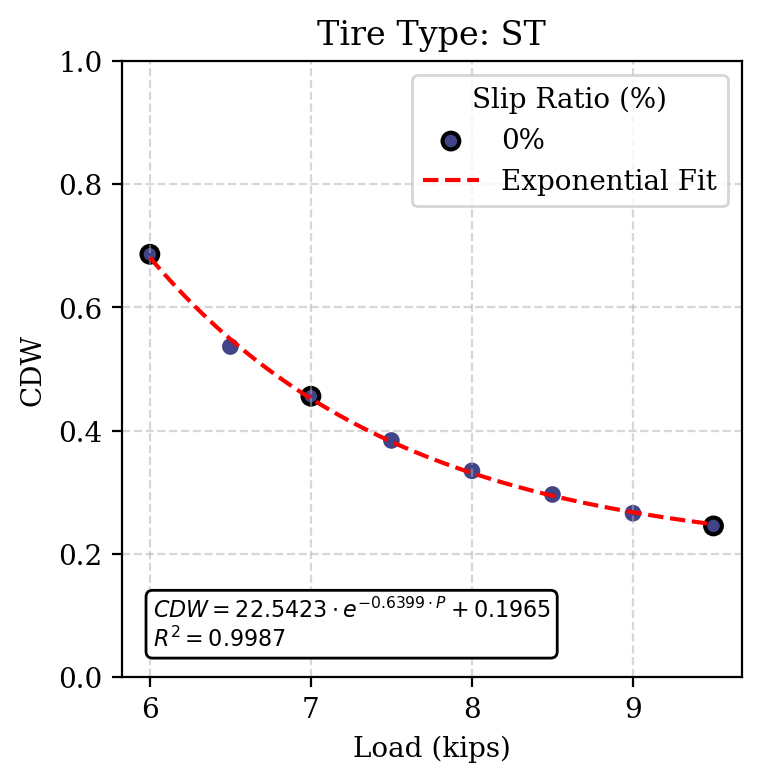

Exponential regression coefficients for Tire Type DTA:
a: 9.9751, b: -0.6045, c: 0.1978
R^2: 0.9974


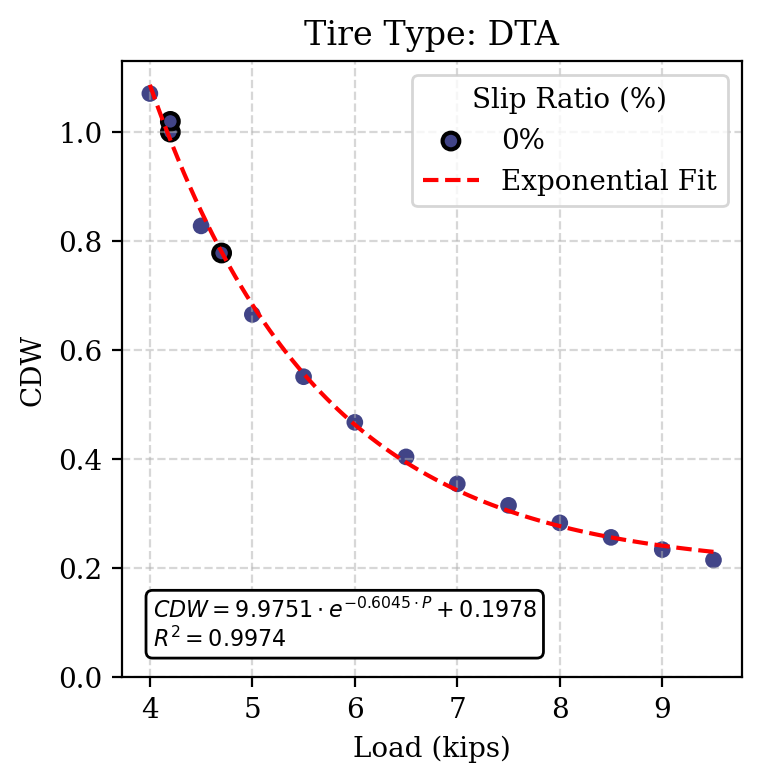

In [108]:
# Load the data from the Excel file
path = r'C:\Users\johan\Box\R27-252 EV\Tasks\Task 4 - Guidelines\Results'
file_path = path + r'\Extrapolated_Results.xlsx'
df = pd.read_excel(file_path, sheet_name='Nf')

# List of unique tire types in the dataframe
tire_types = df['Tire Type'].unique()

# Define marker types and color palette
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'P', '*', 'X']
colors = plt.cm.viridis(np.linspace(0.2, 0.8, 10))

# Create a mapping of slip ratios to markers and colors
marker_map = {0.0: markers[0]}
color_map = {0.0: colors[0]}

# Define an exponential function for fitting
def exponential(x, a, b, c):
    return a * np.exp(b * x) + c

# Loop through each tire type
for tire_type in tire_types:
    # Create a new figure for each tire type
    plt.figure(figsize=(4, 4), dpi=200)
    plt.rc('text', usetex=False)
    plt.rc('font', family='serif')
    
    # Filter the dataframe for the current tire type
    df_tire = df[df['Tire Type'] == tire_type]
    
    # Filter the dataframe for slip ratio 0%
    df_slip_zero = df_tire[df_tire['Slip Ratio'] == 0.00]
    
    edge_color = ['black' if source == 'Simulated' else 'none' for source in df_slip_zero['Data Source']]
    edge_width = [1.5 if source == 'Simulated' else 0.5 for source in df_slip_zero['Data Source']]  # Increase the edge thickness
    
    # Perform exponential fit
    if not df_slip_zero.empty:
        # Provide initial guesses for the parameters (a, b, c)
        initial_guesses = [1, -0.01, df_slip_zero['CDW'].min()]
        
        # Fit an exponential model to the data with initial guesses and increased maxfev
        try:
            popt, pcov = curve_fit(
                exponential, 
                df_slip_zero['Load'], 
                df_slip_zero['CDW'], 
                p0=initial_guesses, 
                maxfev=2000
            )
            
            # Calculate R-squared
            residuals = df_slip_zero['CDW'] - exponential(df_slip_zero['Load'], *popt)
            ss_res = np.sum(residuals**2)
            ss_tot = np.sum((df_slip_zero['CDW'] - np.mean(df_slip_zero['CDW']))**2)
            r_squared = 1 - (ss_res / ss_tot)
            
            # Display exponential coefficients
            print(f'Exponential regression coefficients for Tire Type {tire_type}:')
            print(f'a: {popt[0]:.4f}, b: {popt[1]:.4f}, c: {popt[2]:.4f}')
            print(f'R^2: {r_squared:.4f}')
            
            # Scatter plot for slip ratio 0% with unique marker and color
            plt.scatter(
                df_slip_zero['Load'], 
                df_slip_zero['CDW'], 
                label='0%', 
                marker=marker_map[0.0], 
                color=color_map[0.0],
                edgecolor = edge_color,
                linewidths=edge_width
            )
            
            # Plot the exponential fit curve
            x_vals = np.linspace(df_slip_zero['Load'].min(), df_slip_zero['Load'].max(), 100)
            y_vals = exponential(x_vals, *popt)
            plt.plot(x_vals, y_vals, '--', color='red', label='Exponential Fit')
            
            # Add the regression equation to the plot as a text box
            equation_text = (f'$CDW = {popt[0]:.4f} \cdot e^{{{popt[1]:.4f} \cdot P}} + {popt[2]:.4f} $\n'
                             f'$R^{{2}} = {r_squared:.4f}$')
            plt.text(
                0.05, 0.13, equation_text, transform=plt.gca().transAxes, 
                fontsize=8, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white')
            )
            
        except RuntimeError as e:
            print(f'Failed to fit exponential model for Tire Type {tire_type}: {e}')
    
    # Set the title and labels
    plt.title(f'Tire Type: {tire_type}')
    plt.xlabel('Load (kips)')
    plt.ylabel('CDW')
    plt.yticks(np.arange(0, 1.2, 0.2))
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(title='Slip Ratio (%)')
    
    # Show the plot
    plt.show()


Exponential regression coefficients for Tire Type ST:
a: 12.8721, b: -0.5583, c: 0.1748
R^2: 0.9998


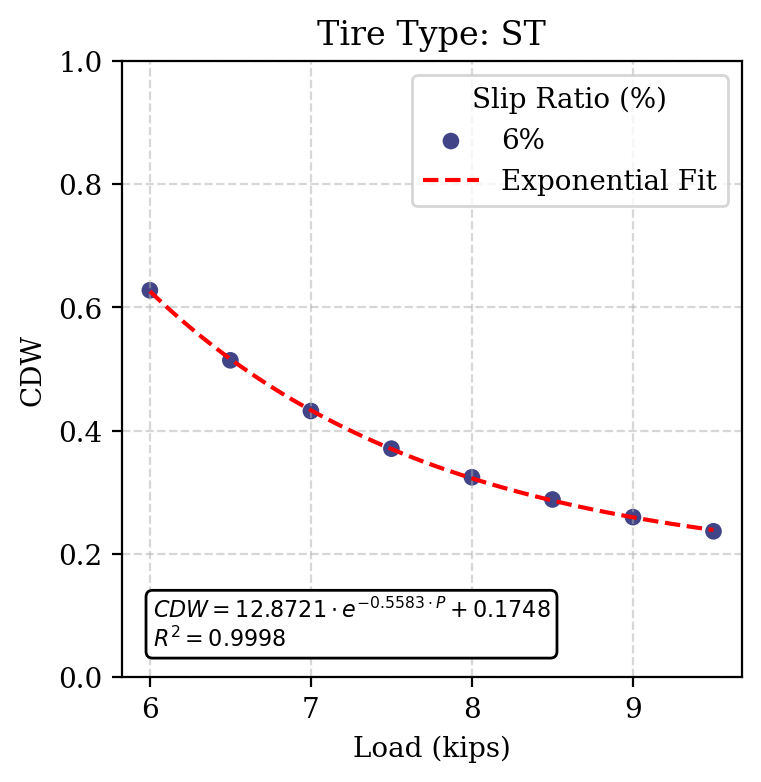

Exponential regression coefficients for Tire Type DTA:
a: 14.4744, b: -0.6606, c: 0.0990
R^2: 0.9981


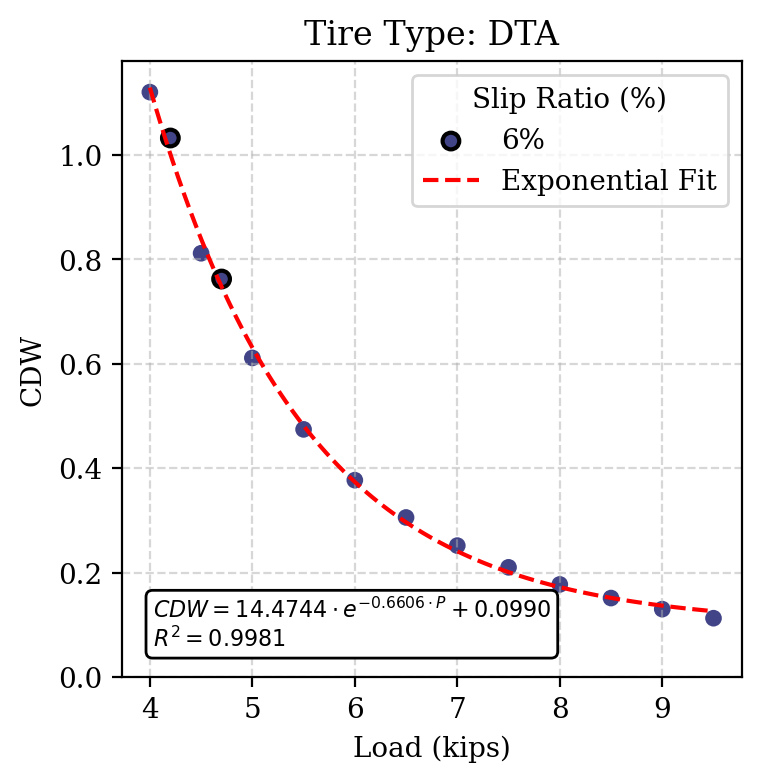

In [107]:
# Load the data from the Excel file
path = r'C:\Users\johan\Box\R27-252 EV\Tasks\Task 4 - Guidelines\Results'
file_path = path + r'\Extrapolated_Results.xlsx'
df = pd.read_excel(file_path, sheet_name='Nf')

# List of unique tire types in the dataframe
tire_types = df['Tire Type'].unique()

# Define marker types and color palette
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'P', '*', 'X']
colors = plt.cm.viridis(np.linspace(0.2, 0.8, 10))

# Create a mapping of slip ratios to markers and colors
marker_map = {0.0: markers[0]}
color_map = {0.0: colors[0]}

# Define an exponential function for fitting
def exponential(x, a, b, c):
    return a * np.exp(b * x) + c

# Loop through each tire type
for tire_type in tire_types:
    # Create a new figure for each tire type
    plt.figure(figsize=(4, 4), dpi=200)
    plt.rc('text', usetex=False)
    plt.rc('font', family='serif')
    
    # Filter the dataframe for the current tire type
    df_tire = df[df['Tire Type'] == tire_type]
    
    # Filter the dataframe for slip ratio 0%
    df_slip_zero = df_tire[df_tire['Slip Ratio'] == 0.06]
    
    edge_color = ['black' if source == 'Simulated' else 'none' for source in df_slip_zero['Data Source']]
    edge_width = [1.5 if source == 'Simulated' else 0.5 for source in df_slip_zero['Data Source']]  # Increase the edge thickness
    
    # Perform exponential fit
    if not df_slip_zero.empty:
        # Provide initial guesses for the parameters (a, b, c)
        initial_guesses = [1, -0.01, df_slip_zero['CDW'].min()]
        
        # Fit an exponential model to the data with initial guesses and increased maxfev
        try:
            popt, pcov = curve_fit(
                exponential, 
                df_slip_zero['Load'], 
                df_slip_zero['CDW'], 
                p0=initial_guesses, 
                maxfev=2000
            )
            
            # Calculate R-squared
            residuals = df_slip_zero['CDW'] - exponential(df_slip_zero['Load'], *popt)
            ss_res = np.sum(residuals**2)
            ss_tot = np.sum((df_slip_zero['CDW'] - np.mean(df_slip_zero['CDW']))**2)
            r_squared = 1 - (ss_res / ss_tot)
            
            # Display exponential coefficients
            print(f'Exponential regression coefficients for Tire Type {tire_type}:')
            print(f'a: {popt[0]:.4f}, b: {popt[1]:.4f}, c: {popt[2]:.4f}')
            print(f'R^2: {r_squared:.4f}')
            
            # Scatter plot for slip ratio 0% with unique marker and color
            plt.scatter(
                df_slip_zero['Load'], 
                df_slip_zero['CDW'], 
                label='6%', 
                marker=marker_map[0.0], 
                color=color_map[0.0],
                edgecolor = edge_color,
                linewidths=edge_width
            )
            
            # Plot the exponential fit curve
            x_vals = np.linspace(df_slip_zero['Load'].min(), df_slip_zero['Load'].max(), 100)
            y_vals = exponential(x_vals, *popt)
            plt.plot(x_vals, y_vals, '--', color='red', label='Exponential Fit')
            
            # Add the regression equation to the plot as a text box
            equation_text = (f'$CDW = {popt[0]:.4f} \cdot e^{{{popt[1]:.4f} \cdot P}} + {popt[2]:.4f} $\n'
                             f'$R^{{2}} = {r_squared:.4f}$')
            plt.text(
                0.05, 0.13, equation_text, transform=plt.gca().transAxes, 
                fontsize=8, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white')
            )
            
        except RuntimeError as e:
            print(f'Failed to fit exponential model for Tire Type {tire_type}: {e}')
    
    # Set the title and labels
    plt.title(f'Tire Type: {tire_type}')
    plt.xlabel('Load (kips)')
    plt.ylabel('CDW')
    plt.yticks(np.arange(0, 1.2, 0.2))
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(title='Slip Ratio (%)')
    
    # Show the plot
    plt.show()

Not enough data points to fit model for Tire Type ST, Slip Ratio 0.03%


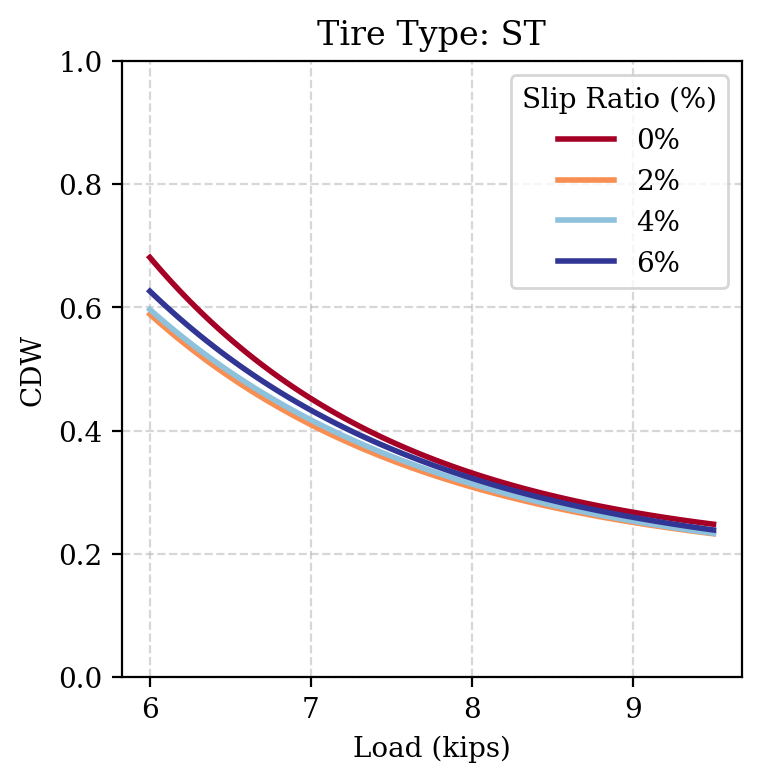

Not enough data points to fit model for Tire Type DTA, Slip Ratio 0.02%
Not enough data points to fit model for Tire Type DTA, Slip Ratio 0.03%
Not enough data points to fit model for Tire Type DTA, Slip Ratio 0.04%


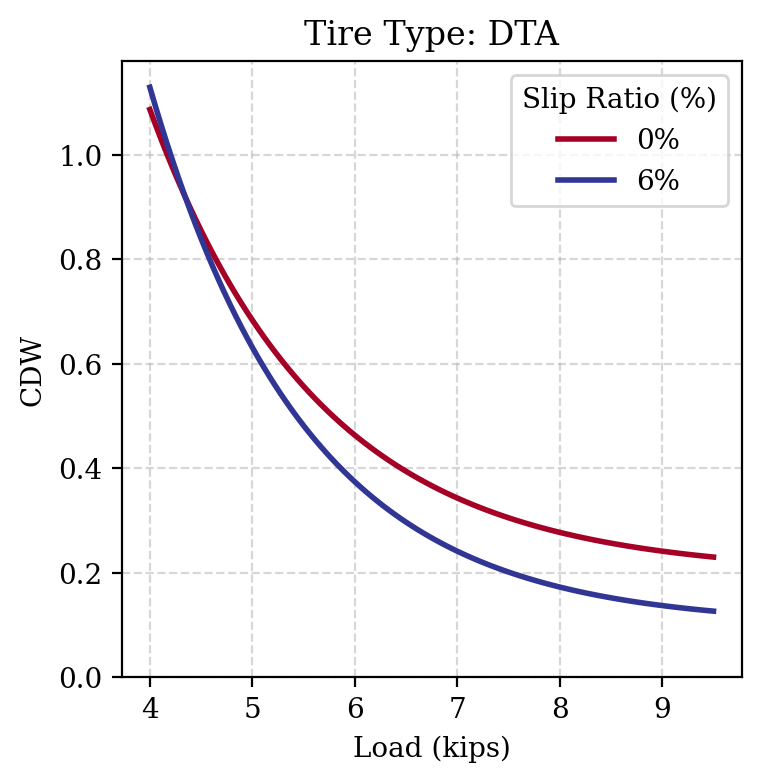

In [92]:
# Load the data from the Excel file
path = r'C:\Users\johan\Box\R27-252 EV\Tasks\Task 4 - Guidelines\Results'
file_path = path + r'\Extrapolated_Results.xlsx'
df = pd.read_excel(file_path, sheet_name='Nf')

# List of unique tire types and slip ratios in the dataframe
tire_types = df['Tire Type'].unique()
slip_ratios = sorted(df['Slip Ratio'].unique())

# Define an exponential function for fitting
def exponential(x, a, b, c):
    return a * np.exp(b * x) + c

# Set matplotlib rc parameters once outside the loop
plt.rc('text', usetex=False)
plt.rc('font', family='serif')

# Define a color palette using the 'viridis' colormap
colors = plt.cm.RdYlBu(np.linspace(0.00, 1.0, len(slip_ratios)))

# Loop through each tire type
for tire_type in tire_types:
    # Create a new figure for each tire type
    plt.figure(figsize=(4, 4), dpi=200)
    
    # Filter the dataframe for the current tire type
    df_tire = df[df['Tire Type'] == tire_type]
    
    # Loop through each slip ratio
    for i, slip_ratio in enumerate(slip_ratios):
        # Filter the dataframe for the current slip ratio
        df_slip = df_tire[df_tire['Slip Ratio'] == slip_ratio]
        
        # Check if there are at least two data points to perform fitting
        if df_slip.shape[0] > 1:
            # Provide dynamic initial guesses for the parameters (a, b, c)
            initial_guesses = [1, -0.01, df_slip['CDW'].min()]
            
            try:
                popt, _ = curve_fit(
                    exponential, 
                    df_slip['Load'], 
                    df_slip['CDW'], 
                    p0=initial_guesses, 
                    maxfev=2000
                )
                
                # Plot the exponential fit curve
                x_vals = np.linspace(df_slip['Load'].min(), df_slip['Load'].max(), 100)
                y_vals = exponential(x_vals, *popt)
                plt.plot(x_vals, y_vals, '-', color=colors[i], label=f'{slip_ratio*100:.0f}%', linewidth=2)
                
                # Add the regression equation to the plot as a text box
                # equation_text = f'$CDW = {popt[0]:.4f} \cdot e^{{{popt[1]:.4f} \cdot P}} + {popt[2]:.4f}$'
                # plt.text(
                #     0.05, 0.90 - 0.05 * slip_ratios.tolist().index(slip_ratio), equation_text, transform=plt.gca().transAxes, 
                #     fontsize=8, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white')
                # )
                
            except RuntimeError as e:
                print(f'Failed to fit exponential model for Tire Type {tire_type}, Slip Ratio {slip_ratio}%: {e}')
        else:
            print(f'Not enough data points to fit model for Tire Type {tire_type}, Slip Ratio {slip_ratio}%')
    
    # Set the title and labels
    plt.title(f'Tire Type: {tire_type}')
    plt.xlabel('Load (kips)')
    plt.ylabel('CDW')
    
    plt.yticks(np.arange(0, 1.2, 0.2))
    
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(title='Slip Ratio (%)')
    
    # Show the plot
    plt.show()


In [142]:
# Define a general function that includes both Load and Slip Ratio as variables
def general_function(x, a, b, c, d):
    load, slip_ratio = x
    return a * np.exp(b * load) + c * slip_ratio + d

# Prepare the data for general model fitting
X = (df['Load'].values, df['Slip Ratio'].values)
Y = df['CDW'].values

# Provide initial guesses for parameters a, b, c, d
initial_guesses_general = [1, -0.01, 1, df['CDW'].min()]

try:
    popt_general, _ = curve_fit(general_function, X, Y, p0=initial_guesses_general, maxfev=5000)
    
    # Display general function coefficients
    print('General model coefficients:')
    print(f'a: {popt_general[0]:.4f}, b: {popt_general[1]:.4f}, c: {popt_general[2]:.4f}, d: {popt_general[3]:.4f}')
    
    # General model equation
    general_equation = f'CDW = {popt_general[0]:.4f} * exp({popt_general[1]:.4f} * Load) + {popt_general[2]:.4f} * Slip Ratio + {popt_general[3]:.4f}'
    print('General model equation:')
    print(general_equation)
    
except RuntimeError as e:
    print(f'Failed to fit general model: {e}')

General model coefficients:
a: 4.4479, b: -0.3938, c: -0.4266, d: 0.1275
General model equation:
CDW = 4.4479 * exp(-0.3938 * Load) + -0.4266 * Slip Ratio + 0.1275


### **DW-Nf**

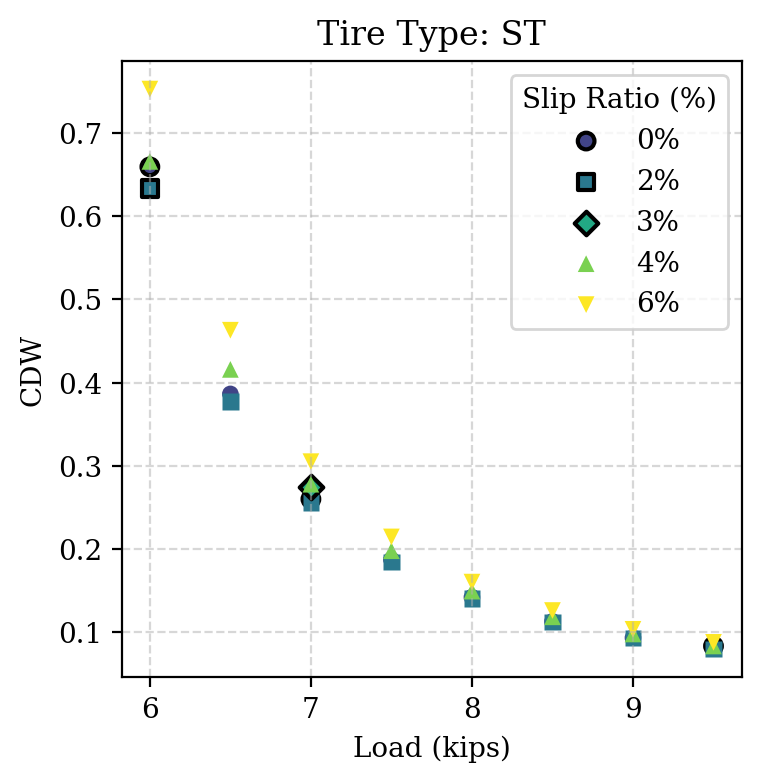

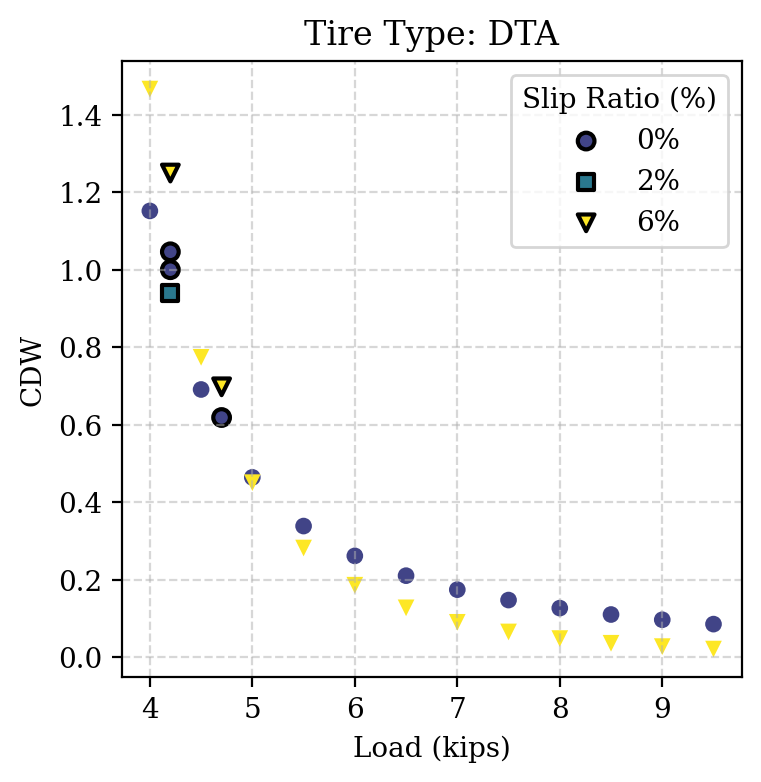

In [87]:
# Load the data from the Excel file
path = r'C:\Users\johan\Box\R27-252 EV\Tasks\Task 4 - Guidelines\Results'  # Using a raw string for the path
file_path = path + r'\Extrapolated_Results.xlsx'  # Constructing the full file path'
df = pd.read_excel(file_path, sheet_name='DW-Nf')


# List of unique tire types in the dataframe
tire_types = df['Tire Type'].unique()

# List of unique slip ratios in the dataframe
unique_slip_ratios = sorted(df['Slip Ratio'].unique())

# Define marker types and color palette
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'P', '*', 'X']
colors = plt.cm.viridis(np.linspace(0.2, 1.0, len(unique_slip_ratios)))

# Create a mapping of slip ratios to markers and colors
marker_map = {slip_ratio: markers[i % len(markers)] for i, slip_ratio in enumerate(unique_slip_ratios)}
color_map = {slip_ratio: colors[i % len(colors)] for i, slip_ratio in enumerate(unique_slip_ratios)}

for tire_type in tire_types:
    # Create a new figure for each tire type
    plt.figure(figsize=(4, 4), dpi=200)
    plt.rc('text', usetex=False)  # Disable TeX to avoid issues with the percentage symbol
    plt.rc('font', family='serif')
    
    # Filter the dataframe for the current tire type
    df_tire = df[df['Tire Type'] == tire_type]
    
    # List to store labels added to the legend
    labels_added = []

    # Loop through each slip ratio and plot them in the same figure
    for slip_ratio in unique_slip_ratios:
        # Filter the dataframe for the current slip ratio
        df_slip = df_tire[df_tire['Slip Ratio'] == slip_ratio]
        
        if not df_slip.empty:  # Check if the dataframe is not empty
            # Scatter plot for the current slip ratio with unique markers and colors
            edge_color = ['black' if source == 'Simulated' else 'none' for source in df_slip['Data Source']]
            edge_width = [1.5 if source == 'Simulated' else 0.5 for source in df_slip['Data Source']]  # Increase the edge thickness
            
            plt.scatter(
                df_slip['Load'], 
                df_slip['CDW'], 
                label=f'{int(slip_ratio * 100)}%', 
                marker=marker_map[slip_ratio], 
                color=color_map[slip_ratio],
                edgecolor = edge_color,
                linewidths=edge_width
            )
            # Add the slip ratio to labels_added to keep track
            labels_added.append(f'{int(slip_ratio * 100)}%')
    
    # Set the title and labels
    plt.title(f'Tire Type: {tire_type}')
    plt.xlabel('Load (kips)')
    plt.ylabel('CDW')
    plt.grid(True, linestyle='--', alpha=0.5)


    
    # Only display legend if there are labels to show
    if labels_added:
        plt.legend(title='Slip Ratio (%)')
    
    # Show the plot
    plt.show()

Exponential regression coefficients for Tire Type ST:
a: 667.0599, b: -1.1763, c: 0.0806
R^2: 0.9986


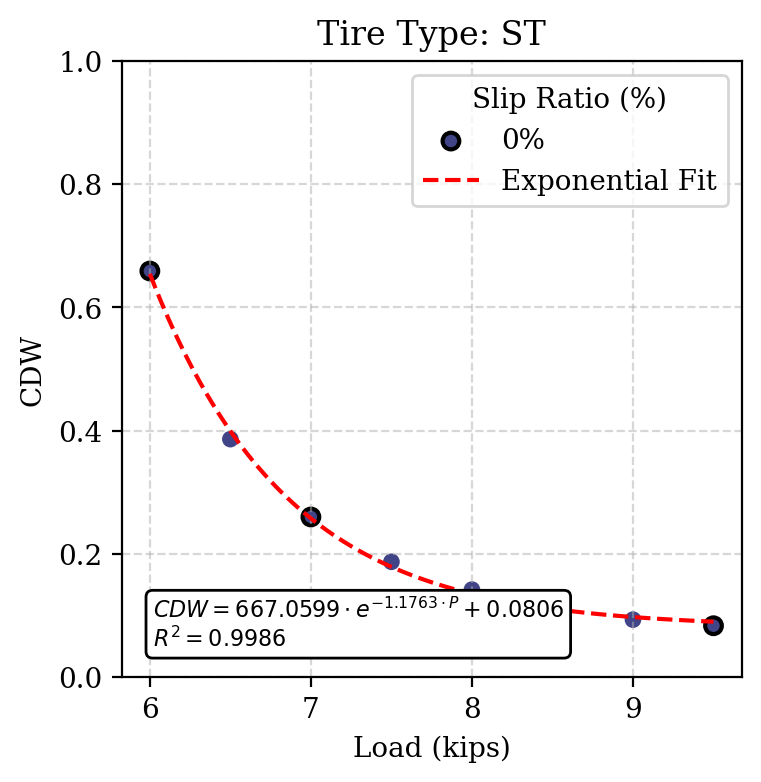

Exponential regression coefficients for Tire Type DTA:
a: 69.0522, b: -1.0406, c: 0.1074
R^2: 0.9941


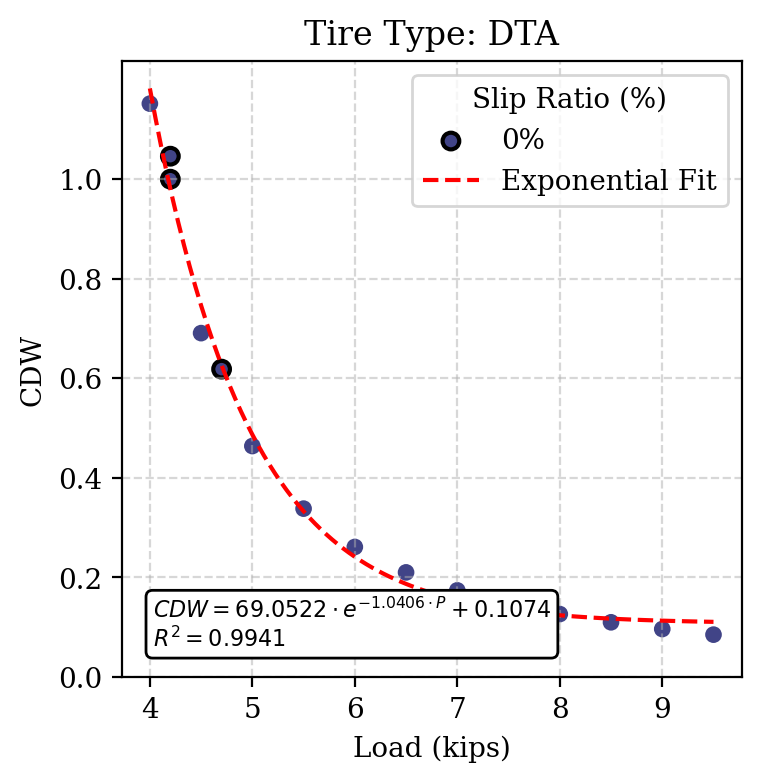

In [109]:
# Load the data from the Excel file
path = r'C:\Users\johan\Box\R27-252 EV\Tasks\Task 4 - Guidelines\Results'
file_path = path + r'\Extrapolated_Results.xlsx'
df = pd.read_excel(file_path, sheet_name='DW-Nf')

# List of unique tire types in the dataframe
tire_types = df['Tire Type'].unique()

# Define marker types and color palette
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'P', '*', 'X']
colors = plt.cm.viridis(np.linspace(0.2, 0.8, 10))

# Create a mapping of slip ratios to markers and colors
marker_map = {0.0: markers[0]}
color_map = {0.0: colors[0]}

# Define an exponential function for fitting
def exponential(x, a, b, c):
    return a * np.exp(b * x) + c

# Loop through each tire type
for tire_type in tire_types:
    # Create a new figure for each tire type
    plt.figure(figsize=(4, 4), dpi=200)
    plt.rc('text', usetex=False)
    plt.rc('font', family='serif')
    
    # Filter the dataframe for the current tire type
    df_tire = df[df['Tire Type'] == tire_type]
    
    # Filter the dataframe for slip ratio 0%
    df_slip_zero = df_tire[df_tire['Slip Ratio'] == 0.00]
    
    edge_color = ['black' if source == 'Simulated' else 'none' for source in df_slip_zero['Data Source']]
    edge_width = [1.5 if source == 'Simulated' else 0.5 for source in df_slip_zero['Data Source']]  # Increase the edge thickness
    
    # Perform exponential fit
    if not df_slip_zero.empty:
        # Provide initial guesses for the parameters (a, b, c)
        initial_guesses = [1, -0.01, df_slip_zero['CDW'].min()]
        
        # Fit an exponential model to the data with initial guesses and increased maxfev
        try:
            popt, pcov = curve_fit(
                exponential, 
                df_slip_zero['Load'], 
                df_slip_zero['CDW'], 
                p0=initial_guesses, 
                maxfev=2000
            )
            
            # Calculate R-squared
            residuals = df_slip_zero['CDW'] - exponential(df_slip_zero['Load'], *popt)
            ss_res = np.sum(residuals**2)
            ss_tot = np.sum((df_slip_zero['CDW'] - np.mean(df_slip_zero['CDW']))**2)
            r_squared = 1 - (ss_res / ss_tot)
            
            # Display exponential coefficients
            print(f'Exponential regression coefficients for Tire Type {tire_type}:')
            print(f'a: {popt[0]:.4f}, b: {popt[1]:.4f}, c: {popt[2]:.4f}')
            print(f'R^2: {r_squared:.4f}')
            
            # Scatter plot for slip ratio 0% with unique marker and color
            plt.scatter(
                df_slip_zero['Load'], 
                df_slip_zero['CDW'], 
                label='0%', 
                marker=marker_map[0.0], 
                color=color_map[0.0],
                edgecolor = edge_color,
                linewidths=edge_width
            )
            
            # Plot the exponential fit curve
            x_vals = np.linspace(df_slip_zero['Load'].min(), df_slip_zero['Load'].max(), 100)
            y_vals = exponential(x_vals, *popt)
            plt.plot(x_vals, y_vals, '--', color='red', label='Exponential Fit')
            
            # Add the regression equation to the plot as a text box
            equation_text = (f'$CDW = {popt[0]:.4f} \cdot e^{{{popt[1]:.4f} \cdot P}} + {popt[2]:.4f} $\n'
                             f'$R^{{2}} = {r_squared:.4f}$')
            plt.text(
                0.05, 0.13, equation_text, transform=plt.gca().transAxes, 
                fontsize=8, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white')
            )
            
        except RuntimeError as e:
            print(f'Failed to fit exponential model for Tire Type {tire_type}: {e}')
    
    # Set the title and labels
    plt.title(f'Tire Type: {tire_type}')
    plt.xlabel('Load (kips)')
    plt.ylabel('CDW')
    plt.yticks(np.arange(0, 1.2, 0.2))
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(title='Slip Ratio (%)')
    
    # Show the plot
    plt.show()


### **ESALs**

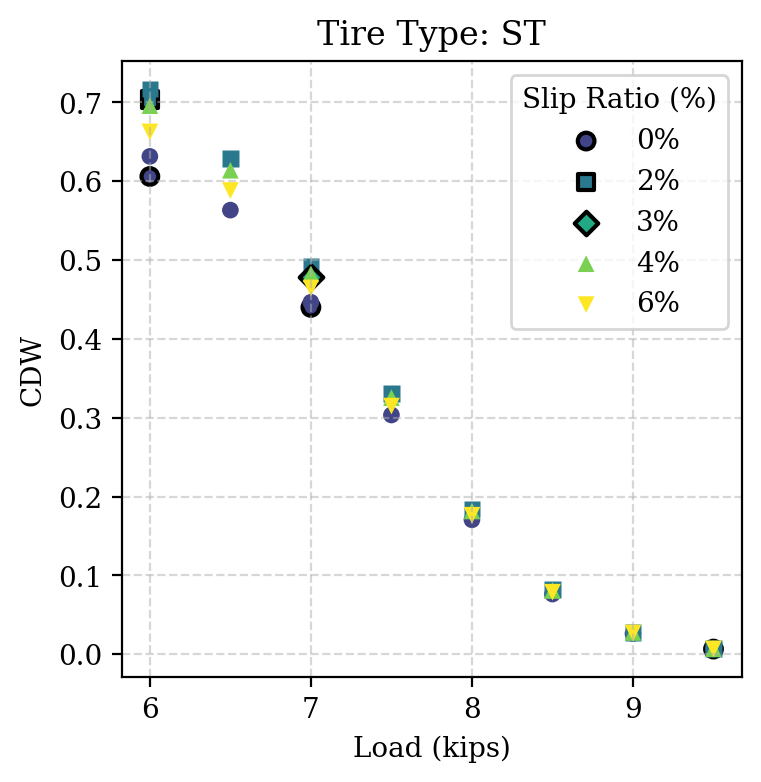

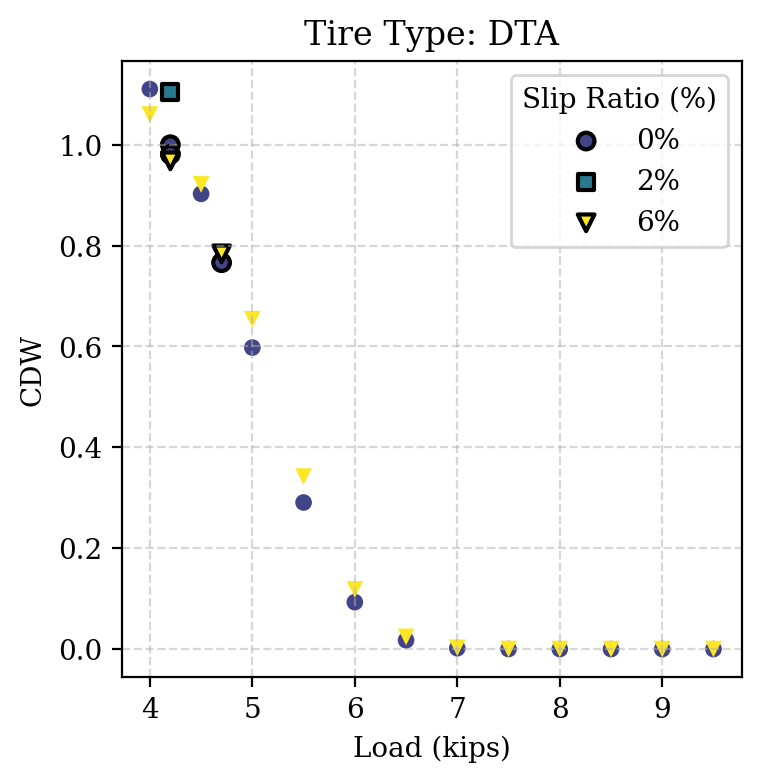

In [45]:
# Load the data from the Excel file
path = r'C:\Users\johan\Box\R27-252 EV\Tasks\Task 4 - Guidelines\Results'  # Using a raw string for the path
file_path = path + r'\Extrapolated_Results.xlsx'  # Constructing the full file path'
df = pd.read_excel(file_path, sheet_name='ESALs')


# List of unique tire types in the dataframe
tire_types = df['Tire Type'].unique()

# List of unique slip ratios in the dataframe
unique_slip_ratios = sorted(df['Slip Ratio'].unique())

# Define marker types and color palette
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'P', '*', 'X']
colors = plt.cm.viridis(np.linspace(0.2, 1.0, len(unique_slip_ratios)))

# Create a mapping of slip ratios to markers and colors
marker_map = {slip_ratio: markers[i % len(markers)] for i, slip_ratio in enumerate(unique_slip_ratios)}
color_map = {slip_ratio: colors[i % len(colors)] for i, slip_ratio in enumerate(unique_slip_ratios)}

for tire_type in tire_types:
    # Create a new figure for each tire type
    plt.figure(figsize=(4, 4), dpi=200)
    plt.rc('text', usetex=False)  # Disable TeX to avoid issues with the percentage symbol
    plt.rc('font', family='serif')
    
    # Filter the dataframe for the current tire type
    df_tire = df[df['Tire Type'] == tire_type]
    
    # List to store labels added to the legend
    labels_added = []

    # Loop through each slip ratio and plot them in the same figure
    for slip_ratio in unique_slip_ratios:
        # Filter the dataframe for the current slip ratio
        df_slip = df_tire[df_tire['Slip Ratio'] == slip_ratio]
        
        if not df_slip.empty:  # Check if the dataframe is not empty
            # Scatter plot for the current slip ratio with unique markers and colors
            edge_color = ['black' if source == 'Simulated' else 'none' for source in df_slip['Data Source']]
            edge_width = [1.5 if source == 'Simulated' else 0.5 for source in df_slip['Data Source']]  # Increase the edge thickness
            
            plt.scatter(
                df_slip['Load'], 
                df_slip['CDW'], 
                label=f'{int(slip_ratio * 100)}%', 
                marker=marker_map[slip_ratio], 
                color=color_map[slip_ratio],
                edgecolor = edge_color,
                linewidths=edge_width
            )
            # Add the slip ratio to labels_added to keep track
            labels_added.append(f'{int(slip_ratio * 100)}%')
    
    # Set the title and labels
    plt.title(f'Tire Type: {tire_type}')
    plt.xlabel('Load (kips)')
    plt.ylabel('CDW')
    plt.grid(True, linestyle='--', alpha=0.5)


    
    # Only display legend if there are labels to show
    if labels_added:
        plt.legend(title='Slip Ratio (%)')
    
    # Show the plot
    plt.show()


Exponential regression coefficients for Tire Type ST:
a: 4.4795, b: -0.1998, c: -0.7032
R^2: 0.9769


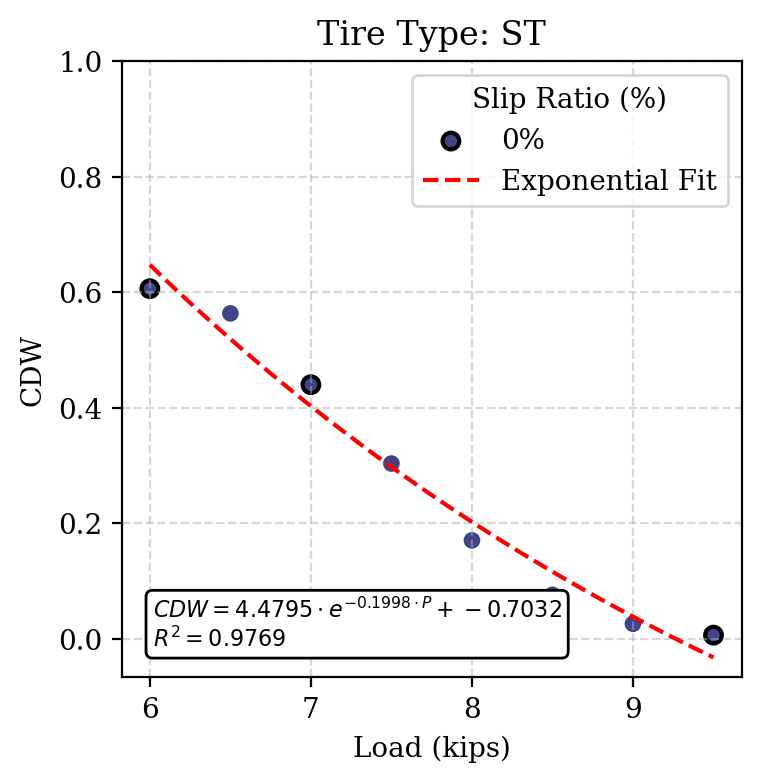

Exponential regression coefficients for Tire Type DTA:
a: 41.1050, b: -0.8820, c: 0.0000
R^2: 0.9687


C:\Users\johan\AppData\Local\Temp\ipykernel_29972\2566889228.py:44: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(


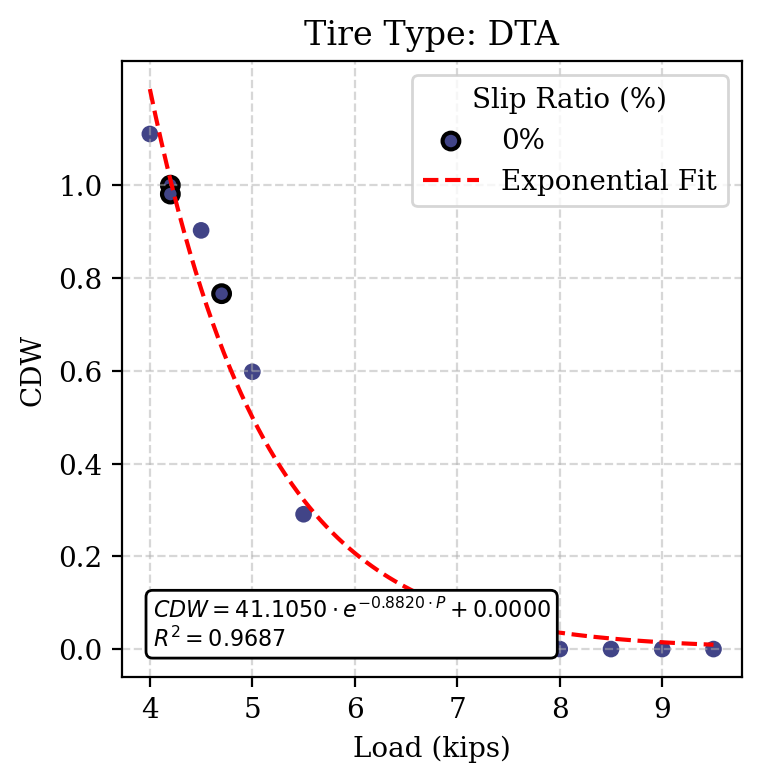

In [110]:
# Load the data from the Excel file
path = r'C:\Users\johan\Box\R27-252 EV\Tasks\Task 4 - Guidelines\Results'
file_path = path + r'\Extrapolated_Results.xlsx'
df = pd.read_excel(file_path, sheet_name='ESALs')

# List of unique tire types in the dataframe
tire_types = df['Tire Type'].unique()

# Define marker types and color palette
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'P', '*', 'X']
colors = plt.cm.viridis(np.linspace(0.2, 0.8, 10))

# Create a mapping of slip ratios to markers and colors
marker_map = {0.0: markers[0]}
color_map = {0.0: colors[0]}

# Define an exponential function for fitting
def exponential(x, a, b, c):
    return a * np.exp(b * x) + c

# Loop through each tire type
for tire_type in tire_types:
    # Create a new figure for each tire type
    plt.figure(figsize=(4, 4), dpi=200)
    plt.rc('text', usetex=False)
    plt.rc('font', family='serif')
    
    # Filter the dataframe for the current tire type
    df_tire = df[df['Tire Type'] == tire_type]
    
    # Filter the dataframe for slip ratio 0%
    df_slip_zero = df_tire[df_tire['Slip Ratio'] == 0.00]
    
    edge_color = ['black' if source == 'Simulated' else 'none' for source in df_slip_zero['Data Source']]
    edge_width = [1.5 if source == 'Simulated' else 0.5 for source in df_slip_zero['Data Source']]  # Increase the edge thickness
    
    # Perform exponential fit
    if not df_slip_zero.empty:
        # Provide initial guesses for the parameters (a, b, c)
        initial_guesses = [1, -0.01, df_slip_zero['CDW'].min()]
        
        # Fit an exponential model to the data with initial guesses and increased maxfev
        try:
            popt, pcov = curve_fit(
                exponential, 
                df_slip_zero['Load'], 
                df_slip_zero['CDW'], 
                p0=initial_guesses, 
                maxfev=2000
            )
            
            # Calculate R-squared
            residuals = df_slip_zero['CDW'] - exponential(df_slip_zero['Load'], *popt)
            ss_res = np.sum(residuals**2)
            ss_tot = np.sum((df_slip_zero['CDW'] - np.mean(df_slip_zero['CDW']))**2)
            r_squared = 1 - (ss_res / ss_tot)
            
            # Display exponential coefficients
            print(f'Exponential regression coefficients for Tire Type {tire_type}:')
            print(f'a: {popt[0]:.4f}, b: {popt[1]:.4f}, c: {popt[2]:.4f}')
            print(f'R^2: {r_squared:.4f}')
            
            # Scatter plot for slip ratio 0% with unique marker and color
            plt.scatter(
                df_slip_zero['Load'], 
                df_slip_zero['CDW'], 
                label='0%', 
                marker=marker_map[0.0], 
                color=color_map[0.0],
                edgecolor = edge_color,
                linewidths=edge_width
            )
            
            # Plot the exponential fit curve
            x_vals = np.linspace(df_slip_zero['Load'].min(), df_slip_zero['Load'].max(), 100)
            y_vals = exponential(x_vals, *popt)
            plt.plot(x_vals, y_vals, '--', color='red', label='Exponential Fit')
            
            # Add the regression equation to the plot as a text box
            equation_text = (f'$CDW = {popt[0]:.4f} \cdot e^{{{popt[1]:.4f} \cdot P}} + {popt[2]:.4f} $\n'
                             f'$R^{{2}} = {r_squared:.4f}$')
            plt.text(
                0.05, 0.13, equation_text, transform=plt.gca().transAxes, 
                fontsize=8, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white')
            )
            
        except RuntimeError as e:
            print(f'Failed to fit exponential model for Tire Type {tire_type}: {e}')
    
    # Set the title and labels
    plt.title(f'Tire Type: {tire_type}')
    plt.xlabel('Load (kips)')
    plt.ylabel('CDW')
    plt.yticks(np.arange(0, 1.2, 0.2))
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(title='Slip Ratio (%)')
    
    # Show the plot
    plt.show()


### **Comparison**

Prediction for $N_{f}$ at 4.7 kips: 0.7800
Prediction for $DW*N_{f}$ at 4.7 kips: 0.6263
Prediction for $ESALs=LEF*N_{f}$ at 4.7 kips: 0.6511


c:\Users\johannc2\AppData\Local\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


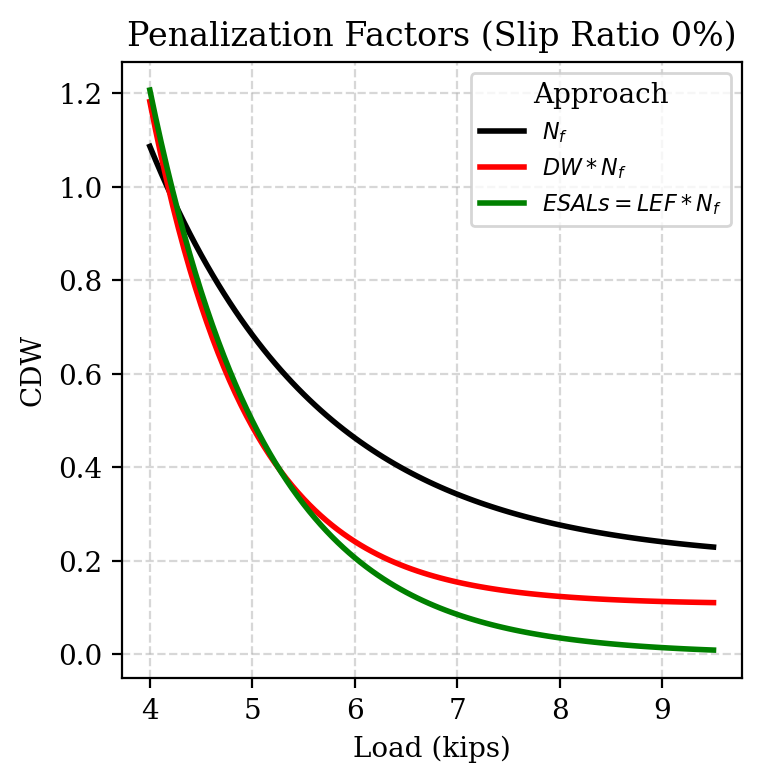

In [6]:
# Load the data from the Excel file
path = r'C:\Users\johannc2\Box\R27-252 EV\Tasks\Task 4 - Guidelines\Results'
file_path = path + r'\Extrapolated_Results.xlsx'
df_nf = pd.read_excel(file_path, sheet_name='Nf')
df_dwnf = pd.read_excel(file_path, sheet_name='DW-Nf')
df_esals = pd.read_excel(file_path, sheet_name='ESALs')

# Define an exponential function for fitting
def exponential(x, a, b, c):
    return a * np.exp(b * x) + c

# Initialize the plot
plt.figure(figsize=(4, 4), dpi=200)
plt.rc('text', usetex=False)
plt.rc('font', family='serif')

# Plotting colors and markers
colors = ['black', 'red', 'green']
labels = ['$N_{f}$', '$DW*N_{f}$', '$ESALs=LEF*N_{f}$']

# Specify the load value for prediction
load_value = 4.7  # kips

# Loop through each dataset
for i, df in enumerate([df_nf, df_dwnf, df_esals]):
    # Filter the dataframe for DTA tires and slip ratio 0%
    df_tire = df[df['Tire Type'] == 'DTA']
    df_slip_zero = df_tire[df_tire['Slip Ratio'] == 0.00]

    # Perform exponential fit
    if not df_slip_zero.empty:
        # Provide initial guesses for the parameters (a, b, c)
        initial_guesses = [1, -0.01, df_slip_zero['CDW'].min()]
        
        try:
            # Fit an exponential model to the data with initial guesses and increased maxfev
            popt, pcov = curve_fit(
                exponential, 
                df_slip_zero['Load'], 
                df_slip_zero['CDW'], 
                p0=initial_guesses, 
                maxfev=2000
            )
            
            # Calculate prediction for the specified load value
            prediction = exponential(load_value, *popt)
            print(f'Prediction for {labels[i]} at {load_value} kips: {prediction:.4f}')
            
            
            # # Scatter plot for slip ratio 0%
            # plt.scatter(
            #     df_slip_zero['Load'], 
            #     df_slip_zero['CDW'], 
            #     label=f'{labels[i]} data', 
            #     marker='o', 
            #     color=colors[i],
            #     edgecolor='black' if i == 0 else 'none',  # Edge color logic
            #     linewidths=1.5 if i == 0 else 0.5  # Line width logic
            # )
            
            # Plot the exponential fit curve
            x_vals = np.linspace(df_slip_zero['Load'].min(), df_slip_zero['Load'].max(), 100)
            y_vals = exponential(x_vals, *popt)
            plt.plot(x_vals, y_vals, '-', color=colors[i], label=f'{labels[i]}', linewidth = 2)

        except RuntimeError as e:
            print(f'Failed to fit exponential model for {labels[i]}: {e}')

# Set the title and labels
plt.title('Penalization Factors (Slip Ratio 0%)')
plt.xlabel('Load (kips)')
plt.ylabel('CDW')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
#title for the legend
plt.legend(title='Approach', fontsize=8)
plt.show()

Predictions for 4.7 kips:
